1. Viz1: /nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220225_1734
2. #path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220225_1734/checkpoints/' 5% mse error for the saved_model_max_recall
3. path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220226_0040/checkpoints' 3% mse for saved_model
 


In [1]:
#path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220226_0040/checkpoints'
path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220302_0137/checkpoints'
saved_model_path = path +'/saved_model.pt'
saved_model_max_recall_path = path + '/saved_model_max_recall.pt'

In [2]:
take = saved_model_max_recall_path

In [3]:

import torch
saved_model = torch.load(take)

In [4]:
import math
import torch
import numpy as np
#from config import *
from misc.utils import *
import torch.nn.functional as F

class PerformancePredictor(torch.nn.Module):
    def __init__(self):
        super(PerformancePredictor, self).__init__()
        self.n_dims = 128
        self.fc = torch.nn.Linear(self.n_dims*2, 1)

    def forward(self, q, m):
        p = torch.cat([q, m], 1)
        p = torch.sigmoid(self.fc(p))
        return p

class ModelEncoder(torch.nn.Module):
    def __init__(self):
        super(ModelEncoder, self).__init__()  
        self.n_dims = 128
        self.fc = torch.nn.Linear(2048, self.n_dims) #torch.nn.Linear(45+1536, self.args.n_dims) 
            
    def forward(self, v_f):
        m = v_f
        m = F.normalize(m)
        m = self.fc(m)
        m = self.l2norm(m)
        return m

    def l2norm(self, x):
        norm2 = torch.norm(x, 2, dim=1, keepdim=True)
        x = torch.div(x, norm2)
        return x
    
class QueryEncoder(torch.nn.Module):
    def __init__(self):
        super(QueryEncoder, self).__init__()
        self.n_dims = 128
        self.fc = torch.nn.Linear(512, self.n_dims) 

    def forward(self, D):
        q = []
        for d in D:
            _q = self.fc(d) 
            _q = torch.mean(_q, 0)
            _q = self.l2norm(_q.unsqueeze(0))
            q.append(_q)
        q = torch.stack(q).squeeze()
        return q

    def l2norm(self, x):
        norm2 = torch.norm(x, 2, dim=1, keepdim=True)
        x = torch.div(x, norm2)
        return x

In [5]:

device = 'cpu'
enc_q = QueryEncoder().to(device) 
enc_q.load_state_dict(saved_model['enc_q'])
enc_m = ModelEncoder().to(device)
enc_m.load_state_dict(saved_model['enc_m'])
pred = PerformancePredictor().to(device)
pred.load_state_dict(saved_model['predictor'])

epoch = saved_model['epoch']
recall = saved_model['recall']
medr = saved_model['medr']
meanr = saved_model['meanr']
mse = saved_model['mse']

In [6]:
model_zoo_path = '/nfs/projects/mbzuai/shikhar/datasets/ofa/our_mod_zoo.pt'
data_path = '/nfs/projects/mbzuai/shikhar/datasets/ofa/our_data_path'
import os
model_zoo = torch.load(model_zoo_path)
query = torch.load(os.path.join(data_path, 'meta_train.pt'))

In [7]:
query.keys()

dict_keys(['fetal_ultrasound', 'CTPancreas', 'IHD_Brain', 'Brain_MRI', 'MosMed', 'RSPECT', 'ProstateMRI', 'kits', 'Covid19XRay', 'LiTs', 'RSNAXRay', 'ImageCHD'])

In [8]:
query['fetal_ultrasound'].keys()

dict_keys(['task', 'clss', 'nclss', 'x_query_train', 'y_query_train', 'x_query_test', 'y_query_test', 'type', 'task_type'])

torch.stack(query['zalando-store-crawl_dqmonn_0_6']['x_query_train']).shape

In [9]:
import pandas as pd
f_model_zoo = pd.DataFrame(model_zoo)

In [11]:
f_model_zoo

,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
471,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
472,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
473,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
474,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


def process_topol(topol):
    ks = topol[:20] 
    e = topol[20:40]
    d = topol[40:]
    tmp = torch.zeros(len(ks))
    for stage, num_layer in enumerate(d):
        tmp[stage*4:stage*4+num_layer] = 1
    ks = torch.tensor(ks) * tmp
    e = torch.tensor(e) * tmp
    topol = [int(t) for t in [*ks.tolist(), *e.tolist(), *d]]
    return topol

In [12]:
set(model_zoo['dataset'])

{'Brain_MRI',
 'CTPancreas',
 'Covid19XRay',
 'IHD_Brain',
 'ImageCHD',
 'LiTs',
 'MosMed',
 'ProstateMRI',
 'RSNAXRay',
 'RSPECT',
 'kits'}

In [14]:
pd.DataFrame(model_zoo)

,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
471,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
472,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
473,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
474,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


Collate Dataset and Model Embeddings.
1. Iterate on all datasets
    1. First embed dataset
    2. Then pick models trained on those datasets. Embed those models.


In [15]:
DATASET_ATTR = {
    "MosMed": {
        "organ": "Lungs",
        "pathologies": "COVID-19",
        "location": ["Russia"],
        "size": 3200,
        "modality": "CT",
        "classes": ["COVID-19 Positive", "COVID-19 Negative"],
    },
    "kits": {
        "organ": "Kidney",
        "pathologies": "Cancer",
        "location": ["USA"],
        "size": 13888,
        "modality": "CT",
        "classes": ["Benign", "Malignant"],
    },
    "LiTs": {
        "organ": "Liver",
        "pathologies": "Cancer",
        "location": ["Germany", "Netherlands", "Canada", "Israel"],
        "size": 8384,
        "modality": "CT",
        "classes": ["No_Tumor", "Tumor"],
    },
    "RSPECT": {
        "organ": "Lungs",
        "pathologies": "Pulmonary Embolism",
        "location": ["Australia", "Turkey", "USA", "Canada", "Brazil"],
        "size": 15000,
        "modality": "CT",
        "classes": ["No_PE", "PE"],
    },
    "IHD_Brain": {
        "organ": "Brain",
        "pathologies": "Intracranial Hemorrhage",
        "location": ["USA", "Brazil"],
        "size": 15000,
        "modality": "CT",
        "classes": ["No_IHD", "IHD"],
    },
    "ImageCHD": {
        "organ": "Heart",
        "pathologies": "Congenital Heart Disease",
        "location": ["China"],
        "size": 6336,
        "modality": "CT",
        "classes": ["No_CHD", "CHD"],
    },
    "CTPancreas": {
        "organ": "Pancreas",
        "pathologies": "Pancreatic Cancer",
        "location": ["USA"],
        "size": 5120,
        "modality": "CT",
        "classes": ["No_Tumor", "Tumor"],
    },
    "Brain_MRI": {
        "organ": "Brain",
        "pathologies": "Brain Tumour",
        "location": ["Global"],
        "size": 3160,
        "modality": "MRI",
        "classes": [
            "glioma_tumor",
            "meningioma_tumor",
            "no_tumor",
            "pituitary_tumor",
        ],
    },
    "ProstateMRI": {
        "organ": "Prostate",
        "pathologies": "Prostate Cancer",
        "location": ["USA"],
        "size": 2561,
        "modality": "MRI",
        "classes": ["No_Tumor", "Tumor"],
    },
    "RSNAXRay": {
        "organ": "Lungs",
        "pathologies": "Tuberculosis",
        "location": ["USA", "China"],
        "size": 801,
        "modality": "Xray",
        "classes": ["No_TB", "TB"],
    },
    "Covid19XRay": {
        "organ": "Lungs",
        "pathologies": "COVID-19",
        "location": ["Spain", "USA"], # Check again
        "size": 6057,
        "modality": "Xray",
        "classes": [
            "Negative for Pneumonia",
            "Typical Appearance",
            "Indeterminate Appearance",
            "Atypical Appearance",
        ],
    },
}


In [16]:
f_model_zoo

,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
471,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
472,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
473,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
474,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [17]:
# Get Trained embeddings
import torch
data_emb_list = list()
n_datasets = 100
i = 1
for dataset in list(set(model_zoo['dataset'])):            
    enc = enc_q([torch.stack(query[dataset]['x_query_train'])])
    d_emb = {'name': f'{dataset}', 'emb': enc.detach().cpu().numpy(), 'dataset': dataset,  'color':i, 'type': 'data'}
    for key, value in DATASET_ATTR[dataset].items():
        d_emb[key] = value

    data_emb_list.append(d_emb)

    dataset_models = f_model_zoo[f_model_zoo['dataset'] == dataset]
    
    # iterate over dataframe

    for index, row in dataset_models.iterrows():
        #model_name = row['model_name']
        #topol = torch.tensor(process_topol(row['topol']))
        enc = enc_m(torch.tensor(row['f_emb']).unsqueeze(0))
        m_emb = {'name': 'M_%.2f'%(row["f1"]), \
            'emb': enc.squeeze().detach().cpu().numpy(), \
            'color':i, 'type': 'model'
            }
        
        row_dict = row.to_dict()
        for key, value in row_dict.items():
           m_emb[key] = value 
            
        data_emb_list.append(m_emb)
        
    i += 1

/tmp/ipykernel_10896/574986753.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc = enc_m(torch.tensor(row['f_emb']).unsqueeze(0))


In [18]:
pd.DataFrame(data_emb_list)

,name,emb,dataset,color,type,organ,pathologies,location,size,modality,...,f1,loss,model_path,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,MosMed,"[-0.069177404, -0.006912787, -0.035915412, -0....",MosMed,1,data,Lungs,COVID-19,[Russia],3200.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M_0.77,"[-0.096387215, -0.032443896, -0.01385965, -0.0...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.768421,0.074524,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,M_0.81,"[-0.027762227, -0.04352185, 0.016885852, -0.04...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.806202,0.170831,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,False,False,False,top-7,"[tensor(0.0108), tensor(0.0750), tensor(0.0112..."
3,M_0.70,"[-0.04911043, 0.012659747, -0.029139956, -0.04...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.703252,0.430663,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,M_0.76,"[-0.03614565, -0.09407476, 0.06746586, -0.0727...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.764286,0.126464,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,False,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,M_0.91,"[0.047282174, -0.07746201, 0.10772579, -0.0048...",Brain_MRI,11,model,NaN,NaN,NaN,NaN,NaN,...,0.910859,0.087698,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,False,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
483,M_0.90,"[0.116918415, -0.08869198, 0.08823783, -0.0758...",Brain_MRI,11,model,NaN,NaN,NaN,NaN,NaN,...,0.897893,0.167773,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,resnet50,True,False,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
484,M_0.94,"[0.090126045, -0.1333912, 0.13822857, 0.032090...",Brain_MRI,11,model,NaN,NaN,NaN,NaN,NaN,...,0.938412,0.024070,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
485,M_0.93,"[0.09938764, 0.0058678295, 0.059740987, -0.014...",Brain_MRI,11,model,NaN,NaN,NaN,NaN,NaN,...,0.927419,0.066011,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,resnet50,True,True,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


### Performance Predictor's prediction of (model, dataset) performance

In [19]:

dataset_list = list(set(model_zoo['dataset']))
predicted_data_model = list()
for dataset in dataset_list:
    for index, row in pd.DataFrame(model_zoo).iterrows():

        # All (Dataset ,Model) pairs. Using model_path as unique identifier of model
        q_encoding = [torch.stack(query[dataset]['x_query_train'])]
        m_encoding = torch.tensor(row['f_emb']).unsqueeze(0)
        q_emb = enc_q(q_encoding).detach().unsqueeze(0).cpu().numpy()
        m_emb = enc_m(m_encoding).detach().cpu().numpy()
        #print(q_emb.shape, m_emb.shape)
        pred_emb = pred(torch.from_numpy(q_emb).to(device), torch.from_numpy(m_emb).to(device))
        pred_emb = pred_emb.detach().cpu().numpy()
        pred_emb = pred_emb.squeeze()
        
        store = {'target_dataset': dataset, 'pred_f1': pred_emb}
        for key, value in row.to_dict().items():
            store[key] = value
        predicted_data_model.append(store)

d_m = pd.DataFrame(predicted_data_model)
# Show all rows
temp = d_m [d_m['target_dataset'] == d_m['dataset']][['target_dataset', 'pred_f1', 'model', 'f1', 'dataset']]
# calculate MSE between temp['f1'], temp['pred_f1'] 
f1 = temp['f1'].to_numpy()
pred_f1 = temp['pred_f1'].to_numpy()
import math, numpy
# calculate Mean Squared Error between f1 and pred_f1
mse = np.mean((f1 - pred_f1)**2)

abs_dif = np.abs(pred_f1 - f1)
# calculate mean, standard deviation of abs_dif
mean = np.mean(abs_dif)
std = np.std(abs_dif)


/tmp/ipykernel_10896/1786645434.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_encoding = torch.tensor(row['f_emb']).unsqueeze(0)


In [20]:
print(mean, std)

0.06135557081863601 0.059663743953701935


### Transfer Learning performance on Validation Samples!

In [59]:
file = 'transfer.csv'
import pandas as pd
transfer = pd.read_csv(file)[['source_model_path','source_dataset','target_dataset','f1']]
predicted_data_model = list()
for index, row in transfer.iterrows():
    
    q_encoding = [torch.stack(query[row['target_dataset']]['x_query_train'])]
    model_info = f_model_zoo[f_model_zoo['model_path'] == row['source_model_path']].reset_index(drop=True)
    m_encoding = torch.tensor(model_info['f_emb'][0]).unsqueeze(0)
    q_emb = enc_q(q_encoding).detach().unsqueeze(0).cpu().numpy()
    m_emb = enc_m(m_encoding).detach().cpu().numpy()
    #print(q_emb.shape, m_emb.shape)
    pred_emb = pred(torch.from_numpy(q_emb).to(device), torch.from_numpy(m_emb).to(device))
    pred_emb = pred_emb.detach().cpu().numpy()
    pred_emb = pred_emb.squeeze()
    predicted_data_model.append({'model': row['source_model_path'], 'target_dataset': row['target_dataset'], 'pred_f1': pred_emb, 'f1': row['f1']})

/tmp/ipykernel_23066/2288285518.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_encoding = torch.tensor(model_info['f_emb'][0]).unsqueeze(0)


file = 'transfer.csv'
import pandas as pd
transfer = pd.read_csv(file)[['source_model_path','source_dataset','target_dataset','f1']]
# Split a pandas dataframe into train and test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(transfer, test_size=0.2, random_state=50)
train_transfer = train.reset_index(drop=True)
test_transfer = test.reset_index(drop=True)
# Write the files using torch
import torch
torch.save(train_transfer, 'train_transfer_1.pt')
torch.save(test_transfer, 'test_transfer_1.pt')

train_transfer['source_model_path']

In [60]:
model_zoo = torch.load('/nfs/projects/mbzuai/shikhar/datasets/ofa/our_mod_zoo.pt')

In [100]:
train_transfer = torch.load('train_transfer.pt')

In [101]:
contents = []
for dataset in list(set(model_zoo['dataset'])):
    models = []
    for idx, _dataset in enumerate(train_transfer['target_dataset']):
        if dataset == _dataset:
            _ixs = np.where(np.array(model_zoo['model_path']) == transfer['source_model_path'][idx])[0]
            for _ix in _ixs:
                models.append({'pred_f1': transfer['f1'][idx],
                'f_emb': model_zoo['f_emb'][_ix],
                'model_path': transfer['source_model_path'][idx],
            })
    contents.append((dataset, models))

In [102]:
for dataset, value in contents:
    print(dataset, len(value))

ImageCHD 35
Brain_MRI 39
ProstateMRI 40
Covid19XRay 44
LiTs 41
IHD_Brain 51
RSPECT 38
kits 56
MosMed 42
CTPancreas 40
RSNAXRay 35


model_zoo['model_path']

In [50]:
x = []
if x == []:
    print('Yes')

Yes


In [62]:
d_m = pd.DataFrame(predicted_data_model)


In [63]:
d_m

,model,target_dataset,pred_f1,f1
0,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,0.45512557,0.484182
1,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78951484,0.707317
2,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,0.8013549,0.872581
3,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,0.74471146,0.775966
4,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,0.6786814,0.803954
...,...,...,...,...
572,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78685516,0.759941
573,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78685516,0.759878
574,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78685516,0.759146
575,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78685516,0.769010


In [64]:

f1 = d_m['f1'].to_numpy()
pred_f1 = d_m['pred_f1'].to_numpy()
import math, numpy
# calculate Mean Squared Error between f1 and pred_f1
mse = np.mean((f1 - pred_f1)**2)

abs_dif = np.abs(pred_f1 - f1)
# calculate mean, standard deviation of abs_dif
mean = np.mean(abs_dif)
std = np.std(abs_dif)
print(mean, std)

0.061146946699898584 0.06609743679617268


for i in range(len(transfer)):
    source_model_path = transfer.iloc[i]['source_model_path']
    source_dataset = transfer.iloc[i]['source_dataset']
    target_dataset = transfer.iloc[i]['target_dataset']
    f1 = transfer.iloc[i]['f1']
    print(source_model_path)
    print(source_dataset)
    print(target_dataset)
    print(f1)
    print('\n')
    enc = enc_q([torch.stack(query[target_dataset]['x_query_train'])])

In [66]:
d_m

,model,target_dataset,pred_f1,f1
0,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,0.45512557,0.484182
1,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78951484,0.707317
2,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,0.8013549,0.872581
3,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,0.74471146,0.775966
4,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSPECT,0.6786814,0.803954
...,...,...,...,...
572,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78685516,0.759941
573,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78685516,0.759878
574,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78685516,0.759146
575,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,0.78685516,0.769010


In [67]:
print(mean, std)
df_pred = d_m[['target_dataset', 'pred_f1', 'model', 'f1', 'model']]

0.061146946699898584 0.06609743679617268


In [68]:
df_pred

,target_dataset,pred_f1,model,f1,model
0,kits,0.45512557,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.484182,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1,IHD_Brain,0.78951484,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.707317,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2,Brain_MRI,0.8013549,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.872581,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
3,RSPECT,0.74471146,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.775966,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
4,RSPECT,0.6786814,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.803954,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
...,...,...,...,...,...
572,IHD_Brain,0.78685516,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.759941,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
573,IHD_Brain,0.78685516,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.759878,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
574,IHD_Brain,0.78685516,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.759146,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
575,IHD_Brain,0.78685516,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.769010,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...


In [70]:
predicted_data_model = list()
for index, row in df_pred.iterrows():
    store = {}
    for key, value in row.to_dict().items():
        store[key] = value
    for key, value in DATASET_ATTR[row['dataset']].items():
        store['source_'+key] = value
    for key, value in DATASET_ATTR[row['target_dataset']].items():
        store['target_'+key] = value
    predicted_data_model.append(store)
d_d = pd.DataFrame(predicted_data_model)

In [71]:
d_d

,target_dataset,pred_f1,model,f1,target_organ,target_pathologies,target_location,target_size,target_modality,target_classes
0,kits,0.45512557,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.484182,Kidney,Cancer,[USA],13888,CT,"[Benign, Malignant]"
1,IHD_Brain,0.78951484,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.707317,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]"
2,Brain_MRI,0.8013549,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.872581,Brain,Brain Tumour,[Global],3160,MRI,"[glioma_tumor, meningioma_tumor, no_tumor, pit..."
3,RSPECT,0.74471146,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.775966,Lungs,Pulmonary Embolism,"[Australia, Turkey, USA, Canada, Brazil]",15000,CT,"[No_PE, PE]"
4,RSPECT,0.6786814,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.803954,Lungs,Pulmonary Embolism,"[Australia, Turkey, USA, Canada, Brazil]",15000,CT,"[No_PE, PE]"
...,...,...,...,...,...,...,...,...,...,...
572,IHD_Brain,0.78685516,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.759941,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]"
573,IHD_Brain,0.78685516,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.759878,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]"
574,IHD_Brain,0.78685516,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.759146,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]"
575,IHD_Brain,0.78685516,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,0.769010,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]"


In [72]:
# 
# use multiindex of fil dataframe to plot heatmap between source and target
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(fil, title = '', x_label = '', y_label = '', cmap = 'Blues'):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(fil, cmap = cmap, annot = True, fmt = '.2f', cbar = False)
    ax.set_title(title)
    # rotate lables to fit
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

def get_bucket(d_d, bucket = 'organ'):
    if bucket == 'dataset':
        return d_d.groupby(['dataset','target_dataset'])['pred_f1'].mean()
    return d_d.groupby([f'source_{bucket}', f'target_{bucket}'])['pred_f1'].mean()

In [73]:
get_bucket(d_d, bucket='dataset').unstack()

KeyError: 'dataset'

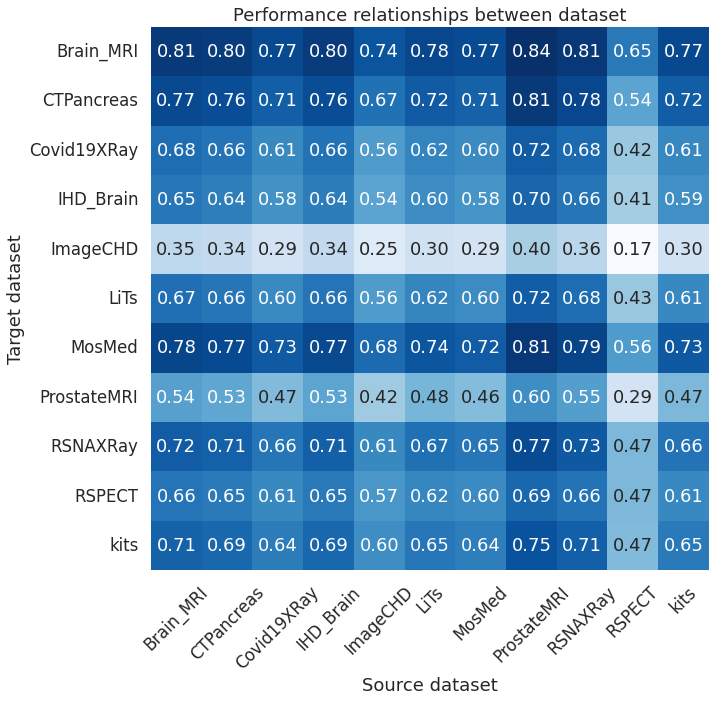

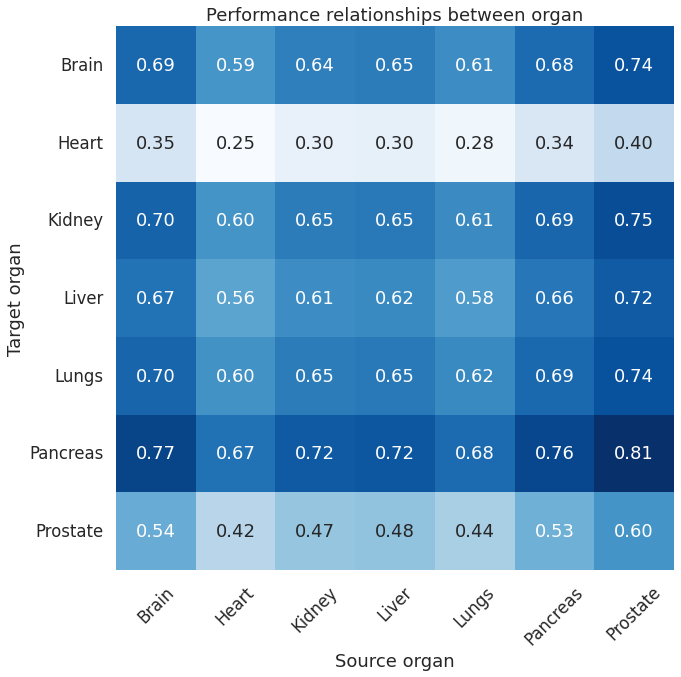

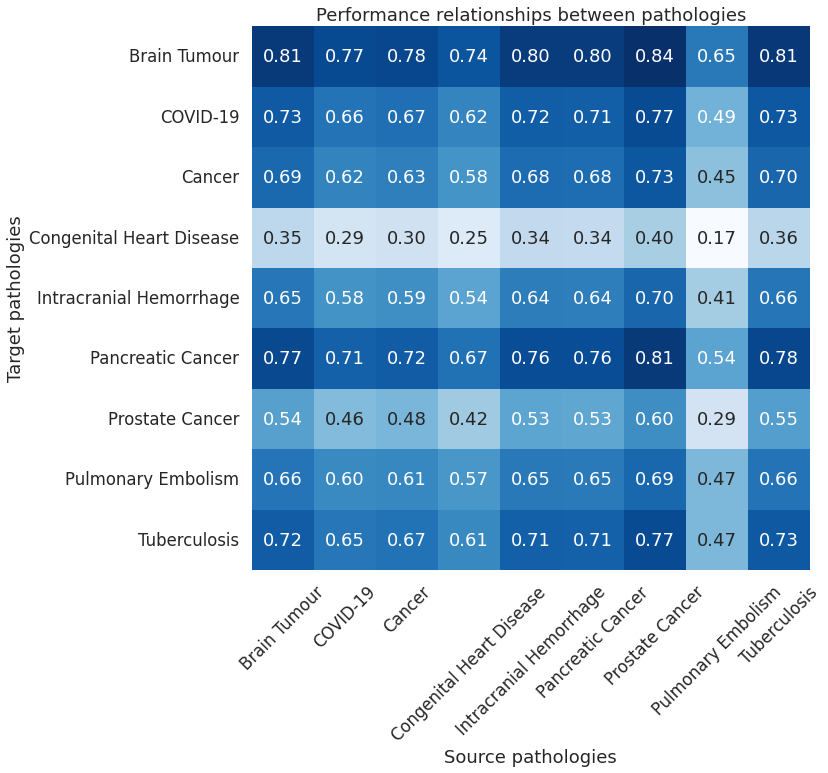

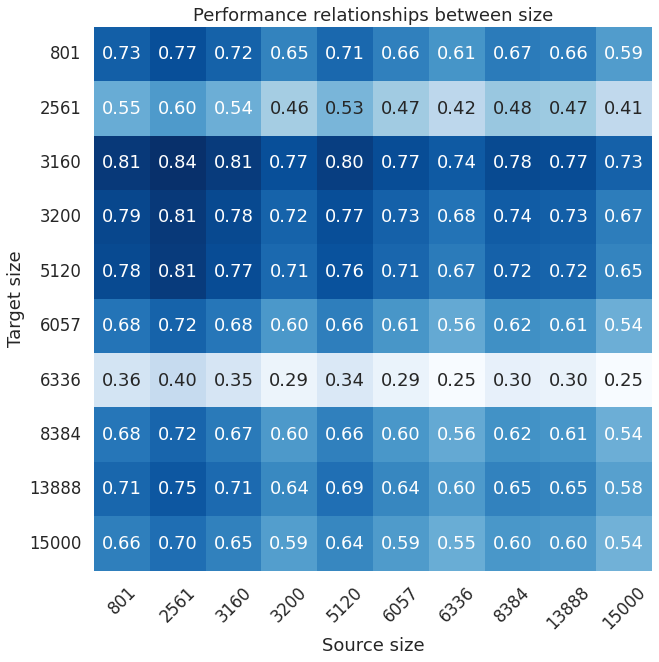

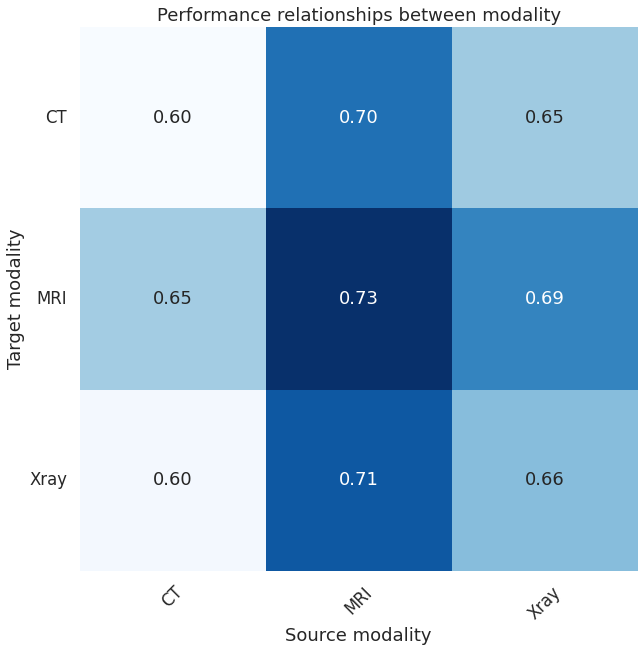

In [197]:
for bucket in ['dataset','organ', 'pathologies', 'size', 'modality']:
    plot_heatmap(get_bucket(d_d, bucket).unstack(), title = f'Performance relationships between {bucket}', x_label = f'Source {bucket}', y_label = f'Target {bucket}')

In [125]:
# Visualize the pred_f1 for each source_organ and target_organ pair
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(df, ax=None, figsize=(10, 10), cmap='viridis', vmin=0, vmax=1):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel('Target Organ')
    ax.set_ylabel('Source Organ')
    ax.set_title('Predicted F1 Score')
    return ax

In [123]:
# Plot heatmap for fil with pred_f1 as values and source_organ as x-axis and target_organ as y-axis 
import seaborn as sns
sns.set(style="whitegrid")
sns.set(font_scale=1.5)
sns.set_context("talk")

def plot_heatmap(fil, x_label, y_label, title, cmap = 'RdYlGn'):
    sns.heatmap(fil, xticklabels=fil[x_label].unique(), yticklabels=fil[y_label].unique(), cmap=cmap)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [124]:
plot_heatmap(fil, 'source_organ', 'target_organ', 'Predicted F1')

ValueError: could not convert string to float: 'Brain'

In [82]:
my_preds.groupby(['dataset','target_dataset']).agg({'pred_f1':'mean'})['pred_f1']

dataset    target_dataset
Brain_MRI  Brain_MRI         0.810856
           CTPancreas        0.802664
           Covid19XRay       0.771019
           IHD_Brain         0.803972
           ImageCHD          0.741061
                               ...   
kits       MosMed            0.635983
           ProstateMRI       0.747864
           RSNAXRay          0.711743
           RSPECT            0.466512
           kits              0.646958
Name: pred_f1, Length: 121, dtype: float64

In [90]:
d_d = my_preds.groupby(['dataset','target_dataset']).agg({'pred_f1':'mean'})['pred_f1'].reset_index()

In [61]:
def filter(final_emb_list, groupby = 'organ', emb= 'avg', dist_from = 'emb'):
    # By dataset
    
    dataset_only = final_emb_list[['dataset',dist_from]].groupby('dataset').mean()
    if groupby == 'dataset':
        return dataset_only
    temp = final_emb_list[final_emb_list['type'] == 'data']
    # Join of temp and dataset_only using column 'dataset'
    temp = temp.join(dataset_only, on='dataset', how='inner', lsuffix='', rsuffix='_globalavg')

    if emb =='avg':
        x = temp[[groupby,f'{dist_from}_globalavg']].groupby(groupby).mean()
        x.rename(columns={f'{dist_from}_globalavg': f'{dist_from}'}, inplace=True)
        return x
    # rename column
    else:
        return temp[[groupby, dist_from]].groupby(groupby).mean()

# Distance matrix calculation
def get_distances(d, dist_from = 'emb'):
    embs = np.array([list(x) for x in d[dist_from].to_list()])
    #print(embs.shape)
    #print(distances)
    labels = list(d.index)
    # calculate euclidian distance matrix
    return squareform(pdist(embs, 'euclidean')), labels

# Matrix to pairwise source, target distance list
def matrix_to_pairwise(distances):
    mat = []
    for i in range(len(distances)):
        for j in range(len(distances)):
            mat.append({'source': labels[i], 'target': labels[j], 'weight': distances[i][j]})
    return pd.DataFrame(mat)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize distance matrix
def visualize_distances(distances, labels, title, log_scale = False):
    plt.figure(figsize=(15,15))
    # try a more diverging cmap color
    plt.imshow(np.log(distances) if log_scale else distances, cmap=plt.cm.RdBu, interpolation=None)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.title(title)
    plt.show()

# To visualize the embeddings as a plot again. For average bucket.
# labels = list(dataset_only[dist_from].index)
# embeddings = list(dataset_only[dist_from].values)
# embeddings = np.array([list(x) for x in embeddings]

## Predicted Performance Bucketing

In [48]:
d_m

,target_dataset,pred_f1,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,CTPancreas,0.7729253,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,CTPancreas,0.5307109,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,CTPancreas,0.41248733,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,CTPancreas,0.7922106,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,CTPancreas,0.3398715,50,0.803333,0.465264,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,efficientnet_b4,True,True,False,True,top-2,"[tensor(0.0083), tensor(0.0193), tensor(0.0648..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4846,RSPECT,0.53243566,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
4847,RSPECT,0.09989687,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4848,RSPECT,0.2506483,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4849,RSPECT,0.3581446,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [ ]:
def filter(groupby = 'organ', emb= 'avg', dist_from = 'emb'):
    # By dataset
    
    dataset_only = final_emb_list[['dataset',dist_from]].groupby('dataset').mean()
    if groupby == 'dataset':
        return dataset_only
    temp = final_emb_list[final_emb_list['type'] == 'data']
    # Join of temp and dataset_only using column 'dataset'
    temp = temp.join(dataset_only, on='dataset', how='inner', lsuffix='', rsuffix='_globalavg')

    if emb =='avg':
        x = temp[[groupby,f'{dist_from}_globalavg']].groupby(groupby).mean()
        x.rename(columns={f'{dist_from}_globalavg': f'{dist_from}'}, inplace=True)
        return x
    # rename column
    else:
        return temp[[groupby, dist_from]].groupby(groupby).mean()

# Distance matrix calculation
def get_distances(d, dist_from = 'emb'):
    embs = np.array([list(x) for x in d[dist_from].to_list()])
    #print(embs.shape)
    #print(distances)
    labels = list(d.index)
    # calculate euclidian distance matrix
    return squareform(pdist(embs, 'euclidean')), labels

# Matrix to pairwise source, target distance list
def matrix_to_pairwise(distances):
    mat = []
    for i in range(len(distances)):
        for j in range(len(distances)):
            mat.append({'source': labels[i], 'target': labels[j], 'weight': distances[i][j]})
    return pd.DataFrame(mat)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize distance matrix
def visualize_distances(distances, labels, title, log_scale = False):
    plt.figure(figsize=(15,15))
    # try a more diverging cmap color
    plt.imshow(np.log(distances) if log_scale else distances, cmap=plt.cm.RdBu, interpolation=None)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.title(title)
    plt.show()

# To visualize the embeddings as a plot again. For average bucket.
# labels = list(dataset_only[dist_from].index)
# embeddings = list(dataset_only[dist_from].values)
# embeddings = np.array([list(x) for x in embeddings]

mean, std : (0.16189234127213195, 0.16484129624616373)

mse:0.053381783110687954

## Visualizations below

In [ ]:
data_emb_list

explained variance ratio (first two components): [0.23517424 0.22483123]


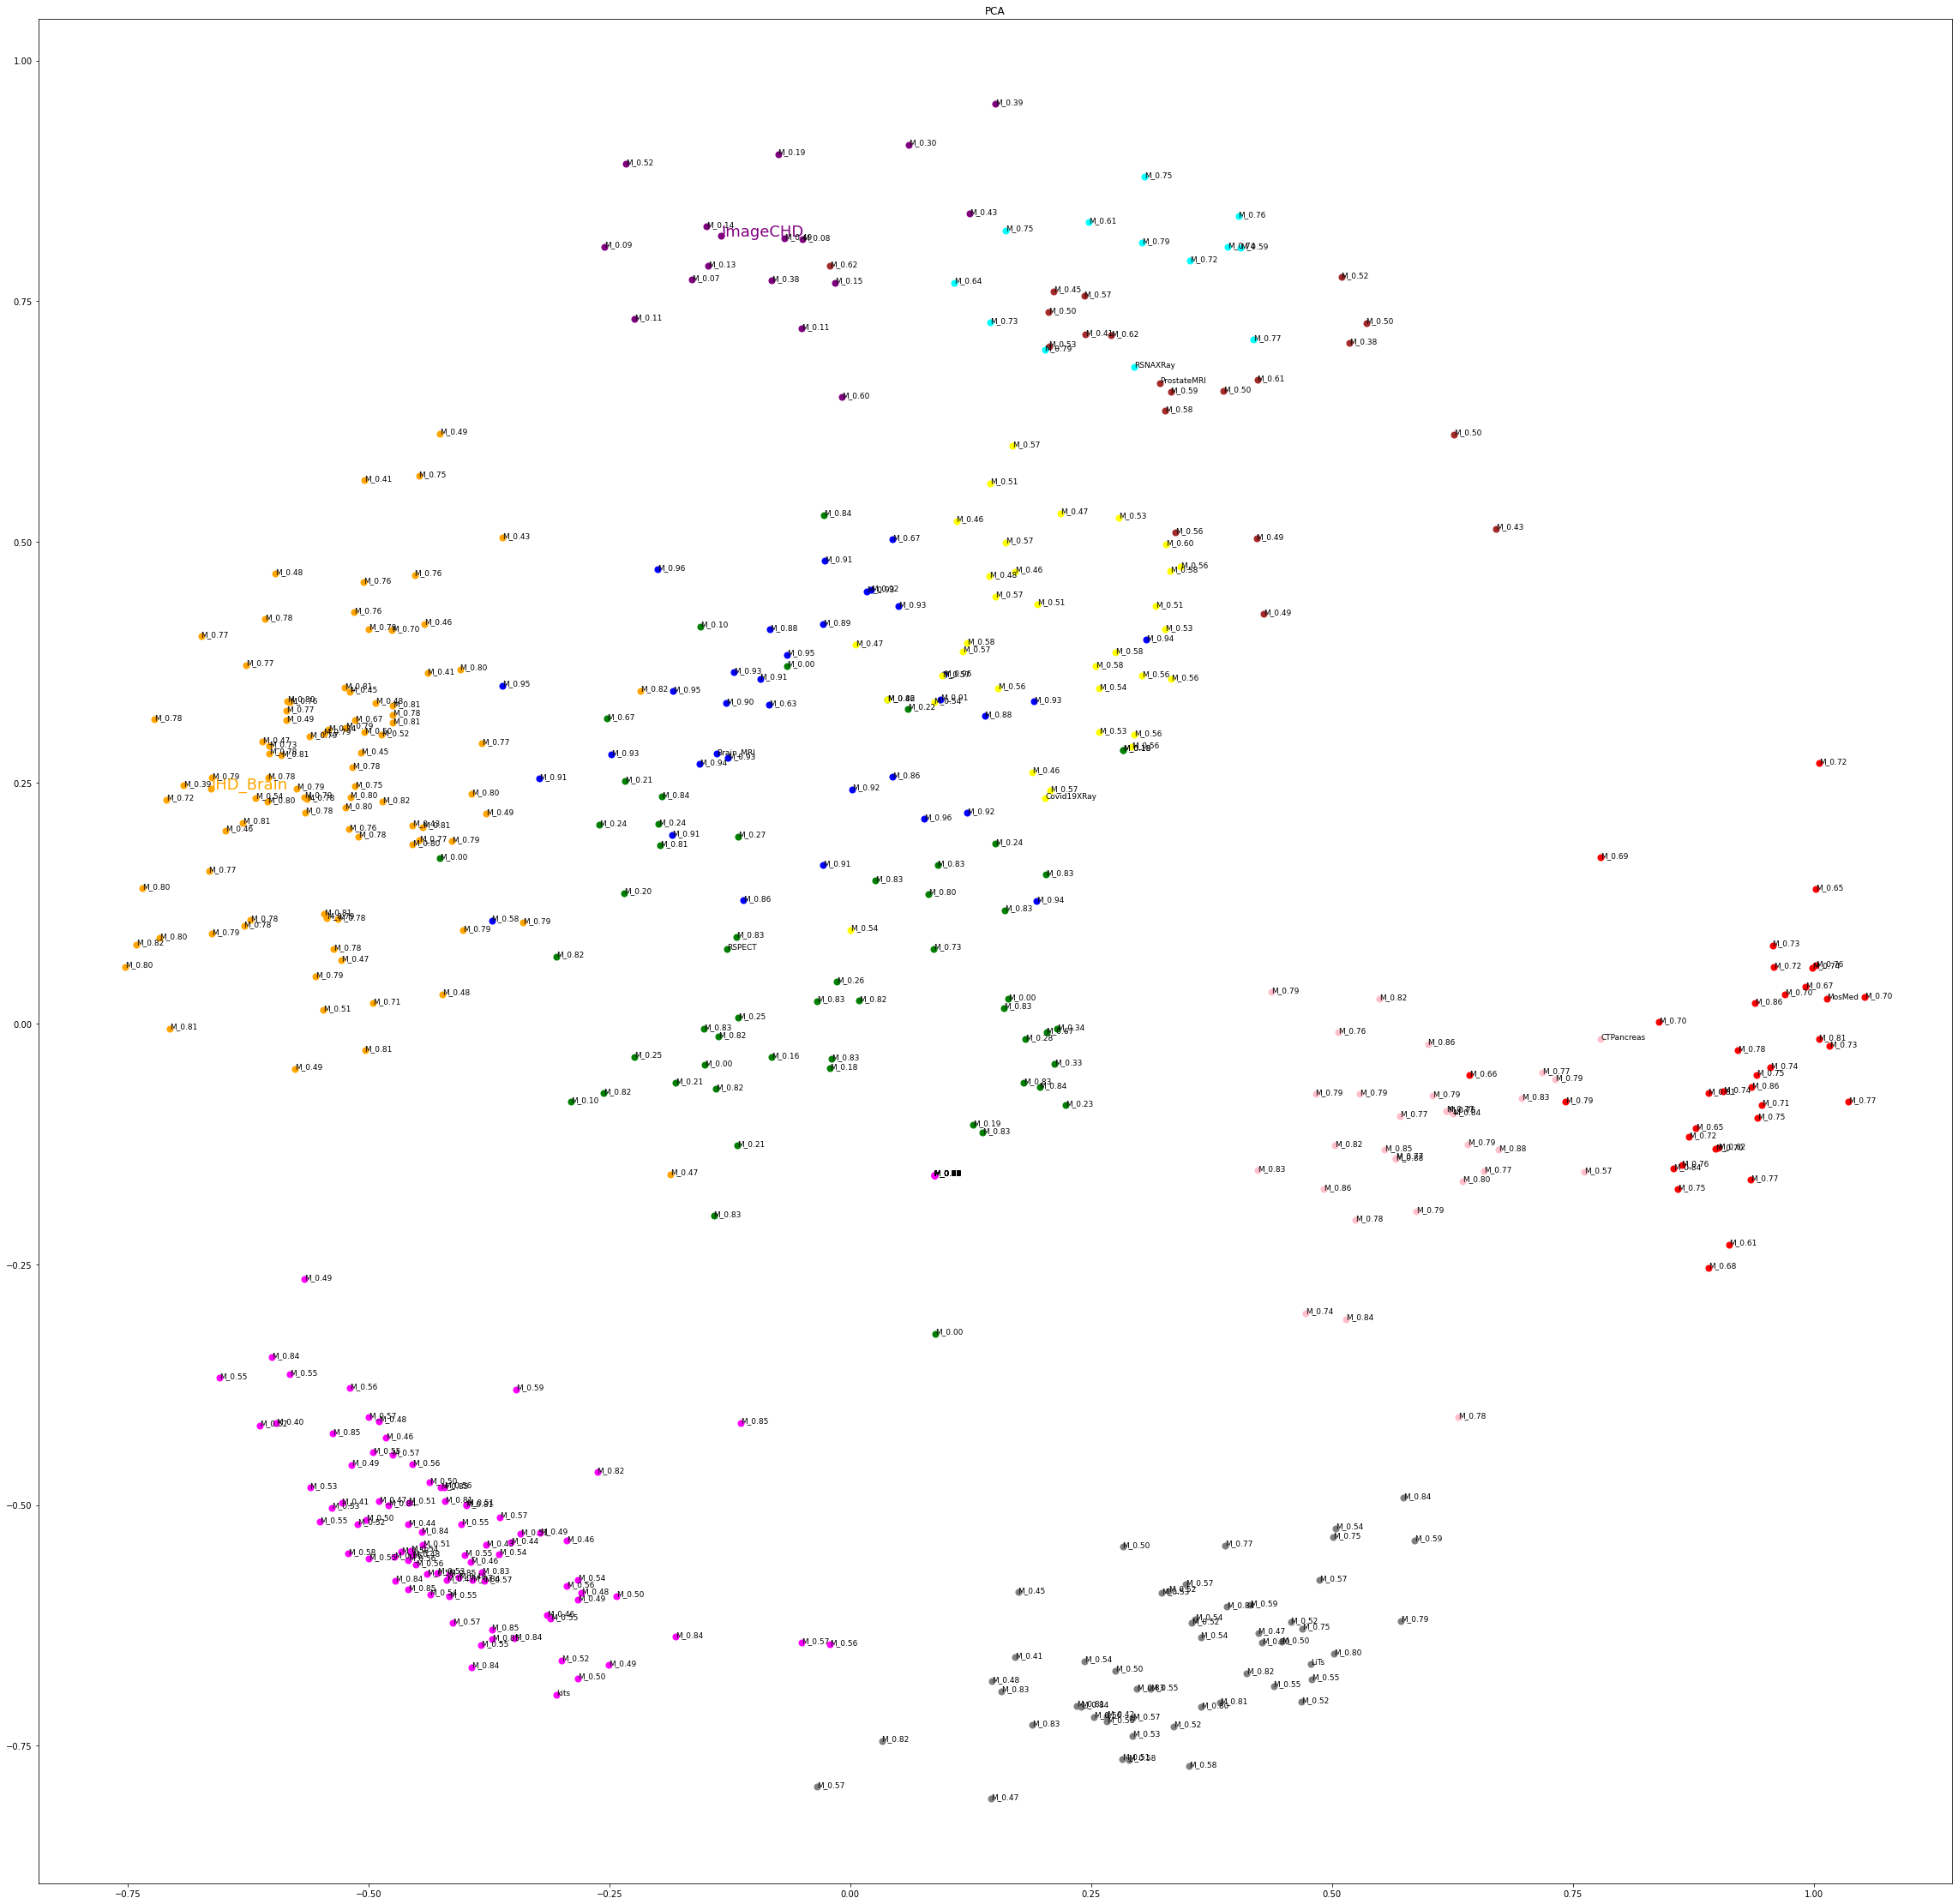

/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 487 samples in 0.000s...
[t-SNE] Computed neighbors for 487 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 487 / 487
[t-SNE] Mean sigma: 0.346121
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.257229
[t-SNE] KL divergence after 300 iterations: 0.343115


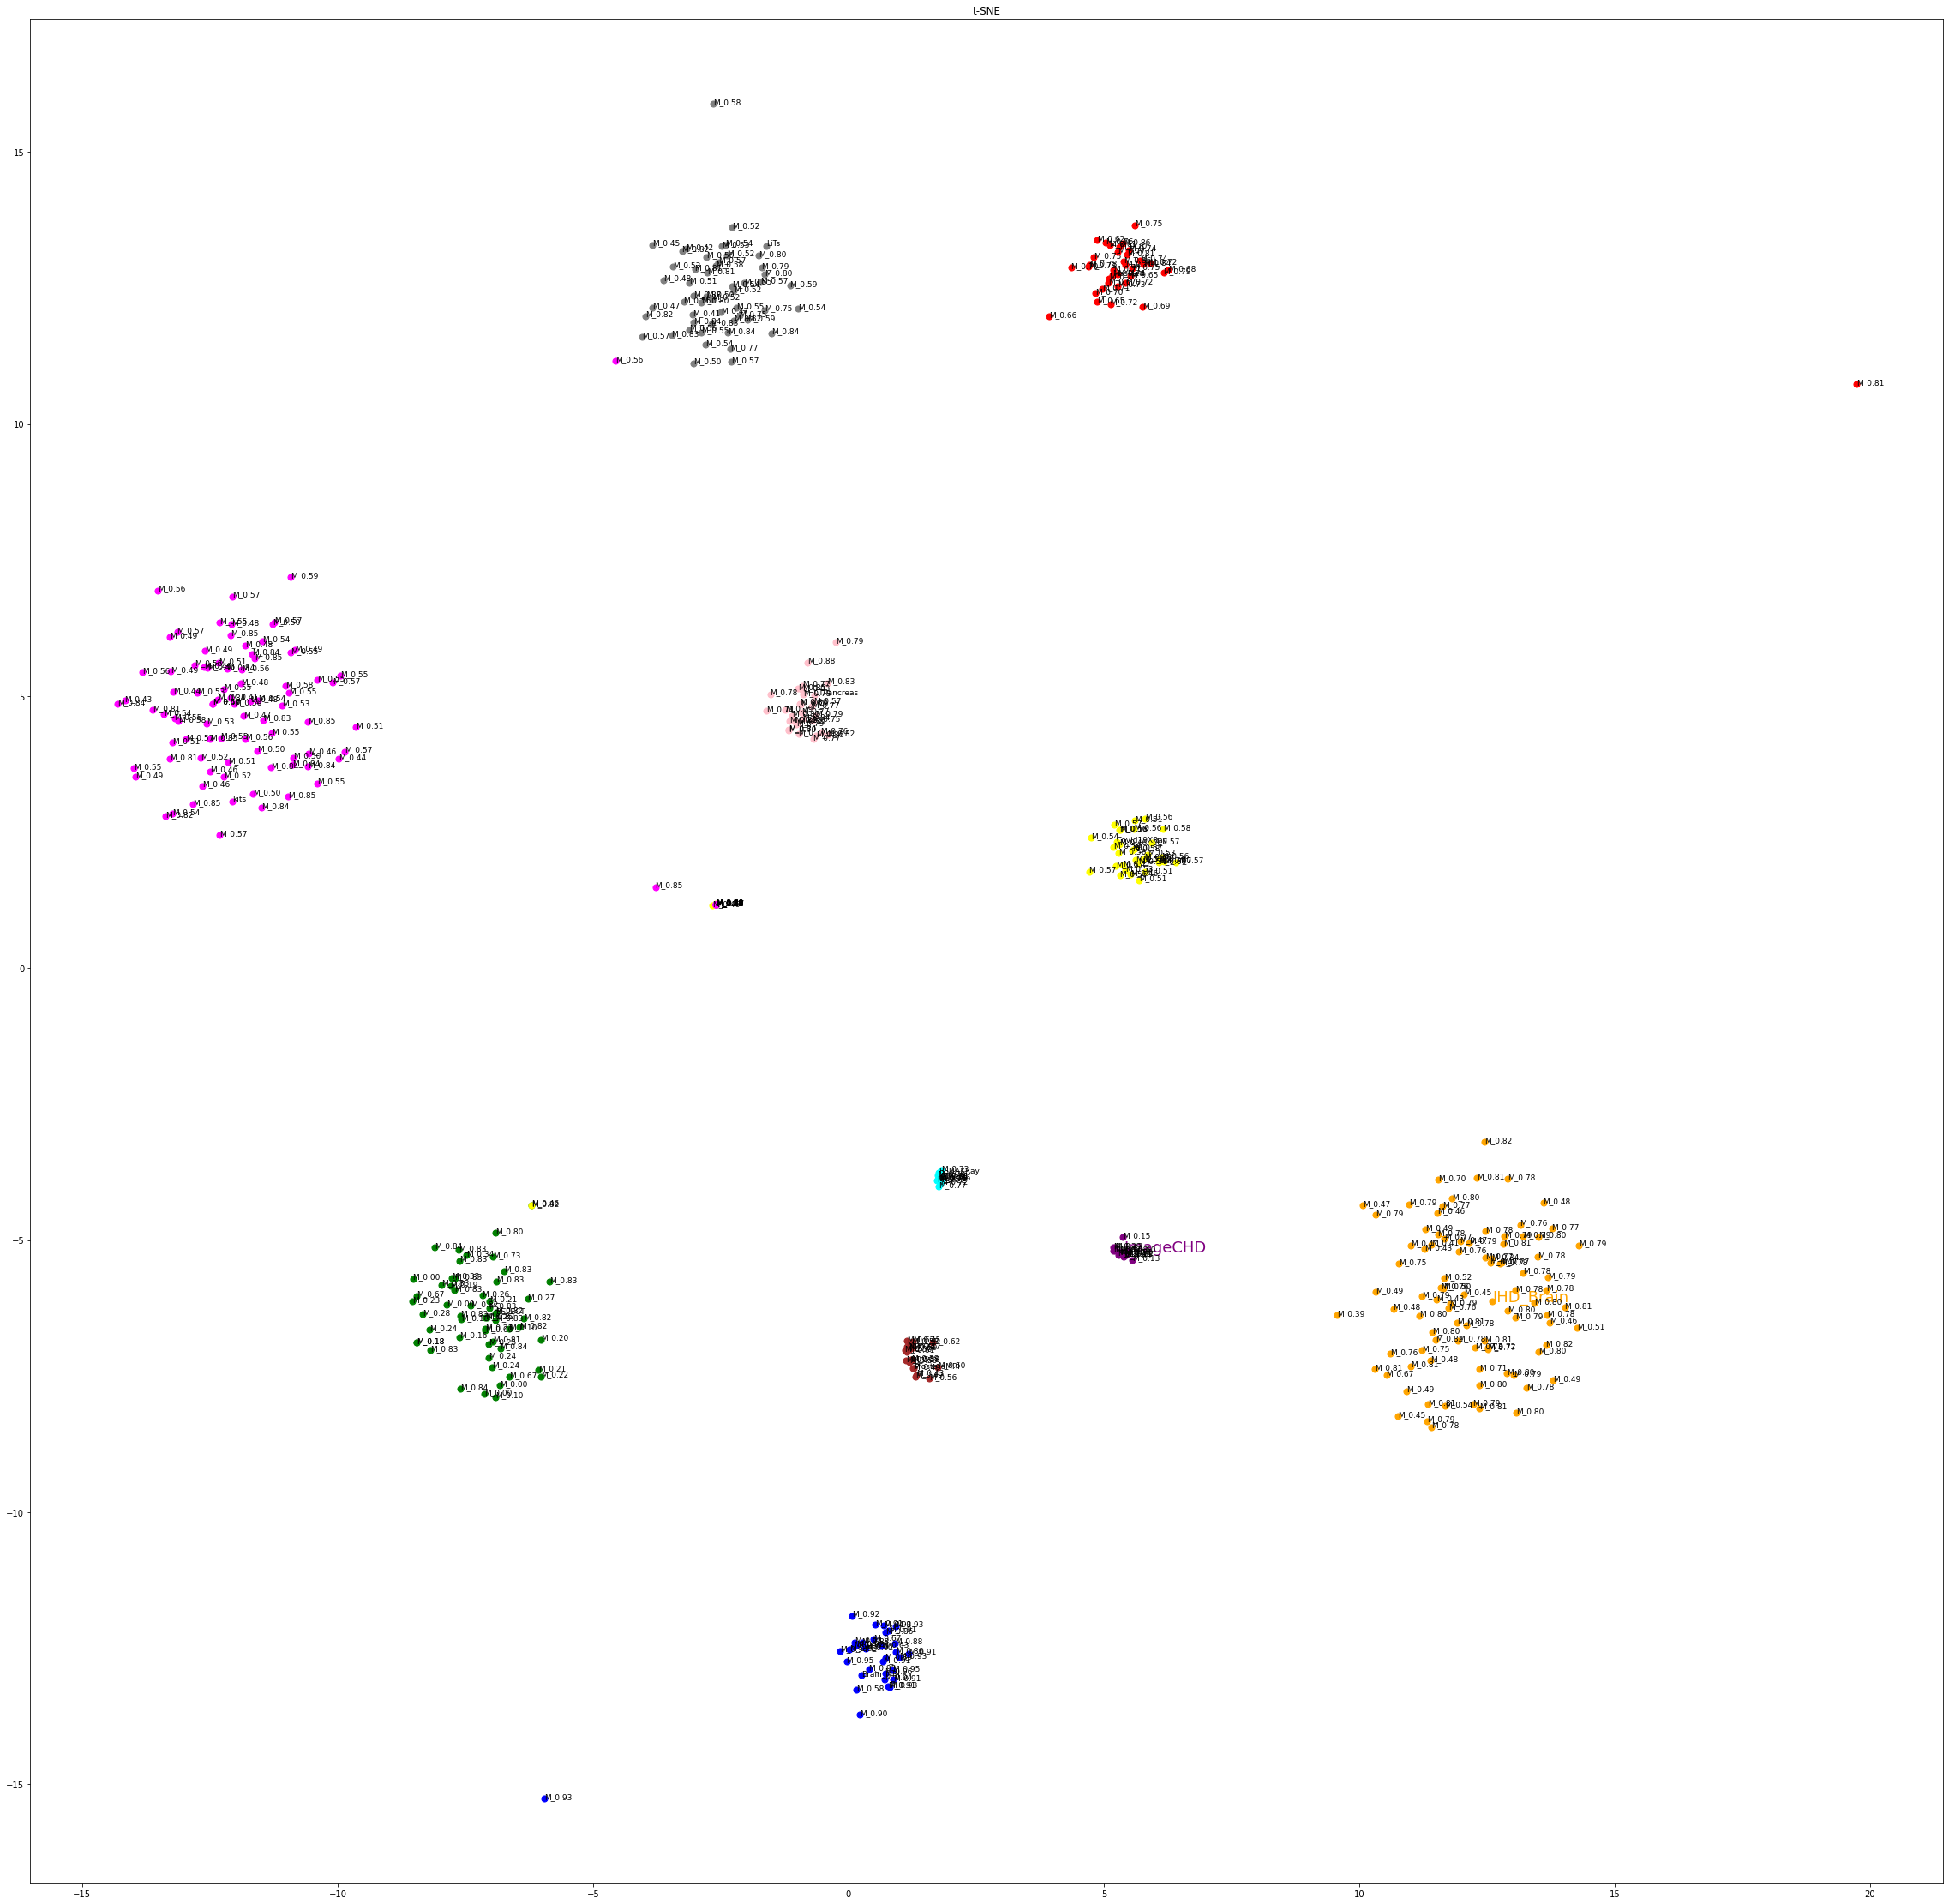

/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 8 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Chan

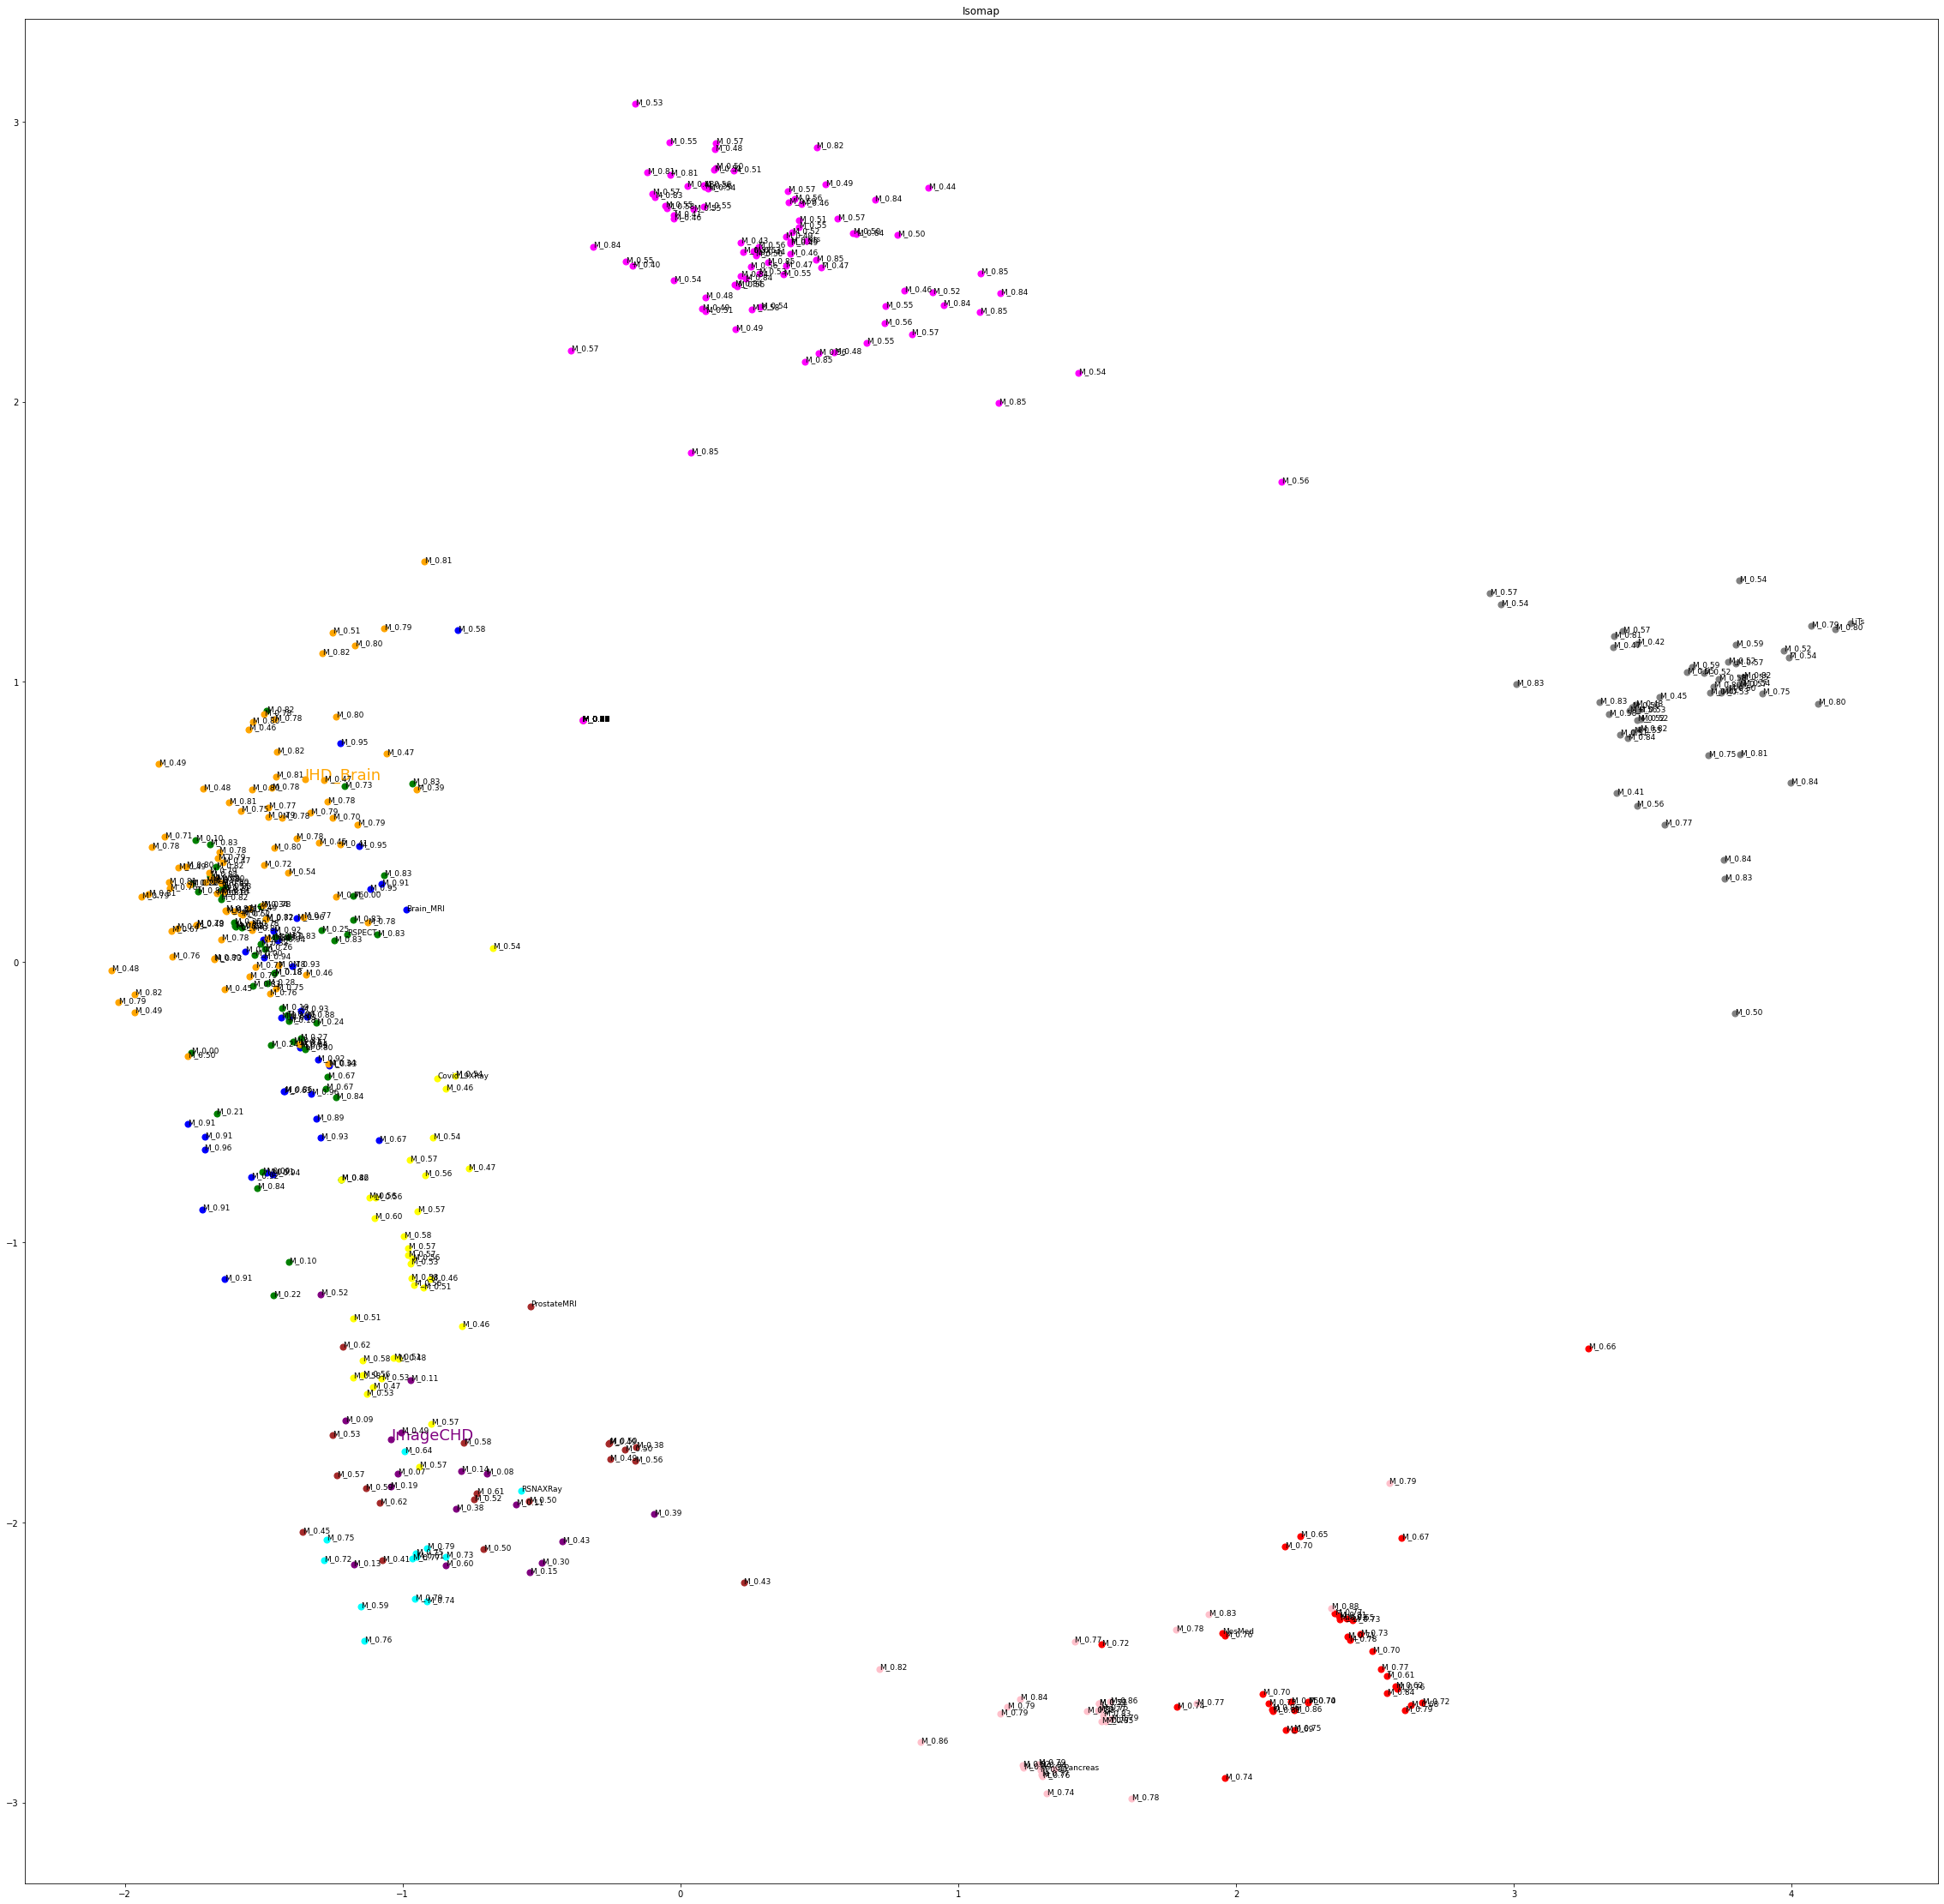

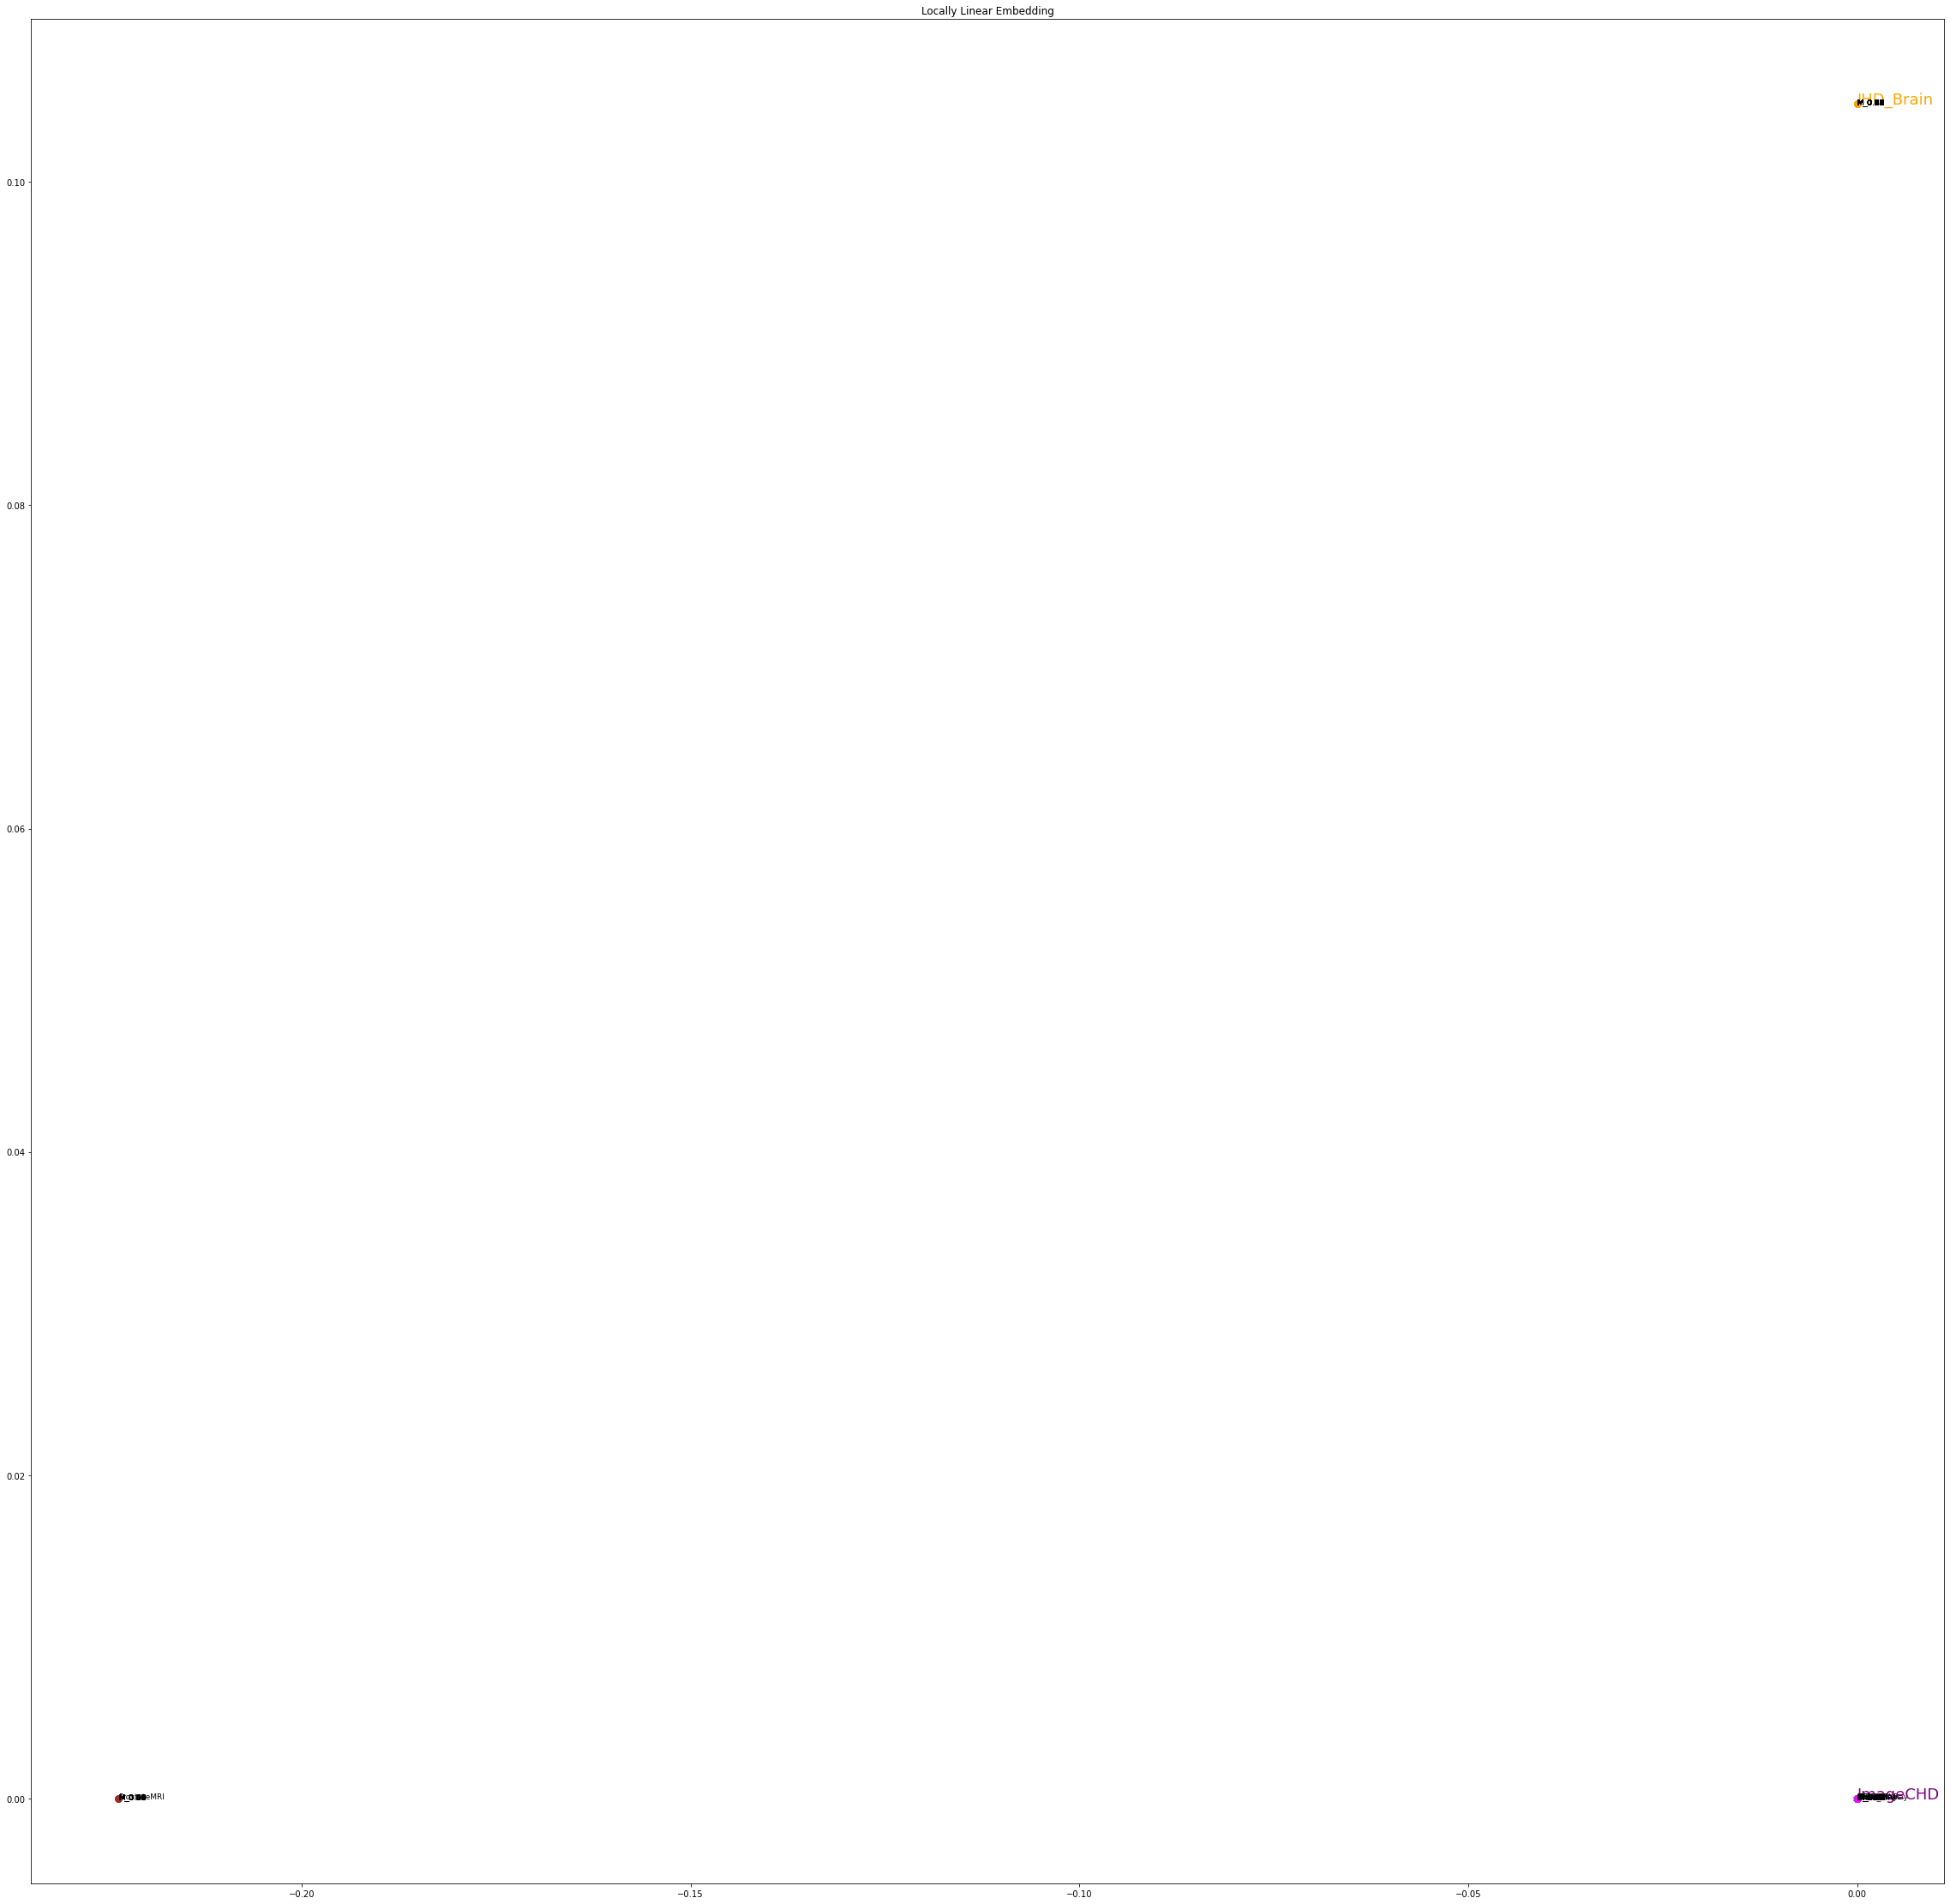

In [75]:
# Do T-sne visualization of the embeddings in data_emb_list
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE, LocallyLinearEmbedding, LocallyLinearEmbedding, SpectralEmbedding, MDS, Isomap
from sklearn.decomposition import PCA

# Visualize embeddings
def visualize_embeddings(data_emb_list, title, method, return_emb=True):
    
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'indigo', 'lime', 'olive', 'teal', 'navy', 'maroon', 'black', 'gold', 'silver', 'gray', 'crimson', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'darkviolet', 'darkcyan', 'darkmagenta', 'darkgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray']

    # Visualize embeddings
    if method == 'tsne':
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        results = tsne.fit_transform([d['emb'] for d in data_emb_list])
    elif method == 'pca':
        pca = PCA(n_components=2)
        results = pca.fit_transform([d['emb'] for d in data_emb_list])
        # print explained variance
        print('explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))
        
    elif method =='isomap':
        isomap = Isomap(n_components=2)
        results = isomap.fit_transform([d['emb'] for d in data_emb_list])
    elif method == 'lle': 
        lle = LocallyLinearEmbedding(n_components=2)
        results = lle.fit_transform([d['emb'] for d in data_emb_list])

    if return_emb:
        return results
        
    plt.figure(figsize=(40, 40))
    
    for i, d in enumerate(data_emb_list):
        x, y = results[i, :]
        plt.scatter(x, y, c=colors[d['color']-1], s=50)
        plt.annotate(d['name'], (x, y), fontsize=18 if 'D' in d['name'] else 9, color=colors[d['color']-1] if 'D' in d['name'] else 'black')
    plt.title(title)
    plt.show()

d = dict()
return_emb = False
d['pca'] = visualize_embeddings(data_emb_list, 'PCA', 'pca', return_emb=return_emb)
d['tsne'] = visualize_embeddings(data_emb_list, 't-SNE', 'tsne', return_emb=return_emb)
d['isomap'] = visualize_embeddings(data_emb_list, 'Isomap', 'isomap', return_emb=return_emb)
d['lle'] = visualize_embeddings(data_emb_list, 'Locally Linear Embedding', 'lle', return_emb=return_emb)
import pandas as pd
true = pd.DataFrame(data_emb_list)
true_emb = np.array(pd.DataFrame(true['emb']).values.tolist()).squeeze(1)

In [80]:
# Compute the distance matrix
from scipy.spatial.distance import pdist, squareform

def compute_distances(emb):
    return squareform(pdist(emb, 'euclidean'))
    # Calculate euclidian error between two distance matrices
def euclidian_error(true_distances, distances):
    return np.sqrt(np.sum(np.square(true_distances - distances)))
# Compute the distance matrix for true_emb
true_distances = compute_distances(true_emb)
viz_d = dict()
for key, value in d.items():
    viz_d[key] = compute_distances(value)
# iterate over all d methods and print euclidian error
for key, value in viz_d.items():
    print('Euclidian error for %s: %.2f'%(key, euclidian_error(true_distances, value)))

ValueError: A 2-dimensional array must be passed.

# Final Visualizations

In [79]:
final_emb_list = pd.DataFrame(data_emb_list.copy())
final_emb_list['pca'] = list(d['pca'])
final_emb_list['tsne'] = list(d['tsne'])
final_emb_list['isomap'] = list(d['isomap'])
final_emb_list['lle'] = list(d['lle'])

TypeError: 'NoneType' object is not iterable

In [77]:
final_emb_list

,name,emb,dataset,color,type,organ,pathologies,location,size,modality,...,f1,loss,model_path,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,MosMed,"[-0.089984424, -0.045577157, 0.0006870302, -0....",MosMed,1,data,Lungs,COVID-19,[Russia],3200.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M_0.77,"[-0.10296164, -0.036361415, -0.02605725, -0.05...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.768421,0.074524,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,M_0.81,"[-0.055676047, -0.10405411, 0.035289347, -0.05...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.806202,0.170831,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,False,False,False,top-7,"[tensor(0.0108), tensor(0.0750), tensor(0.0112..."
3,M_0.70,"[-0.058265425, -0.0014995013, -0.038544506, -0...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.703252,0.430663,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,M_0.76,"[-0.044704508, -0.04442563, 0.03578481, -0.089...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.764286,0.126464,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,False,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,M_0.43,"[0.024404459, -0.031318676, 0.07949292, -0.111...",kits,11,model,NaN,NaN,NaN,NaN,NaN,...,0.431718,0.216921,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
483,M_0.56,"[0.042013235, 0.031435814, 0.040825017, -0.145...",kits,11,model,NaN,NaN,NaN,NaN,NaN,...,0.563284,0.097940,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
484,M_0.48,"[0.017970871, 0.05761504, 0.011546174, -0.1353...",kits,11,model,NaN,NaN,NaN,NaN,NaN,...,0.483431,0.377908,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,False,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
485,M_0.57,"[0.029439833, -0.01940978, 0.059047423, -0.022...",kits,11,model,NaN,NaN,NaN,NaN,NaN,...,0.572048,0.259978,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,True,False,True,raw,"[tensor(0.0146), tensor(0.0086), tensor(-0.001..."


In [40]:
# Only datasets
only_datasets = final_emb_list[final_emb_list['type'] == 'data'].reset_index(drop=True)
only_datasets

,name,emb,dataset,color,type,organ,pathologies,location,size,modality,...,with_aug,balanced,pretrained,batch_128,topn,f_emb,pca,tsne,isomap,lle
0,CTPancreas,"[0.030353606, -0.01666533, 0.009352372, -0.049...",CTPancreas,1,data,Pancreas,Pancreatic Cancer,[USA],5120.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.47901624918416447, 0.416779686484988]","[0.16640197, 9.385475]","[2.1186227530698245, 0.13977715612565433]","[-0.02059531905105267, 0.049241475823072575]"
1,Covid19XRay,"[-0.0034292024, -0.12297956, 0.04125863, 0.163...",Covid19XRay,2,data,Lungs,COVID-19,"[Spain, USA]",6057.0,Xray,...,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.0224714088503632, 0.8890269607506622]","[2.4487493, -3.1660788]","[-1.4678604757124682, -2.9669489050311046]","[-0.0011591949020558746, 0.002119330509649987]"
2,ProstateMRI,"[-0.09362787, -0.1284755, 0.09661629, 0.006832...",ProstateMRI,3,data,Prostate,Prostate Cancer,[USA],2561.0,MRI,...,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.019816409165398365, 0.5596179041965181]","[-4.637644, -7.176751]","[-2.826954332108924, 0.04244406369783233]","[0.00012973755050550852, 1.2949075916670109e-05]"
3,RSNAXRay,"[0.041793037, -0.14861888, 0.040412918, 0.1341...",RSNAXRay,4,data,Lungs,Tuberculosis,"[USA, China]",801.0,Xray,...,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.1972296603473292, 0.8174228405228892]","[3.1099212, -2.9772308]","[-1.2554653434943723, -2.5727769979465203]","[-0.002004908018948485, 0.0035422523449910115]"
4,IHD_Brain,"[0.18802893, 0.032412868, 0.15384611, -0.03726...",IHD_Brain,5,data,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.2975062130212552, 0.21913036060037744]","[8.145916, -12.470039]","[-0.7870584793949009, 0.5451772232651203]","[-0.0009654170835808708, -0.0007609979359530956]"
5,ImageCHD,"[0.02255252, -0.07418152, 0.0823191, 0.0287113...",ImageCHD,6,data,Heart,Congenital Heart Disease,[China],6336.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.15056480206608092, 0.9424293891403287]","[-0.08136715, -9.001224]","[-0.3897777254889751, 4.136637101557174]","[0.0001953647315926587, 9.807168234654094e-05]"
6,kits,"[0.0078063966, 0.088252224, 0.037197687, -0.16...",kits,7,data,Kidney,Cancer,[USA],13888.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.012108790033022608, -0.7555568365620584]","[-13.155562, -3.4964292]","[-0.955363508308438, 0.7472408078859977]","[-0.13825973036517797, 0.012751894153826389]"
7,MosMed,"[-0.13392113, 0.022607952, -0.04765662, 0.0988...",MosMed,8,data,Lungs,COVID-19,[Russia],3200.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.9740719618467292, 0.621575178044981]","[-1.88484, 16.895601]","[4.003706306432839, -0.46119831145372847]","[1.8260668763492743e-05, 0.0009294724313080007]"
8,Brain_MRI,"[-0.056361463, 0.022324974, 0.07564775, -0.155...",Brain_MRI,9,data,Brain,Brain Tumour,[Global],3160.0,MRI,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.00360696125952424, 0.1145244262886184]","[-3.9082396, -11.662825]","[-0.4276266691297819, 2.12222432435241]","[0.00032209010960754063, 4.11277277867161e-05]"
9,LiTs,"[-0.0755608, 0.09183614, 0.008208295, -0.08735...",LiTs,10,data,Liver,Cancer,"[Germany, Netherlands, Canada, Israel]",8384.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.8053341464559366, -0.2554214818420881]","[-11.374792, 9.418933]","[1.4786967932364492, 0.03983403601122307]","[0.018947538935232478, 0.13601566344328161]"


In [41]:
def convert_to_df(grouped, columns = ['name','emb']):
    # Convert dictionary to dataframe with columns as keys and values as values
    new_dict = dict()
    for key, value in grouped.to_dict()['emb'].items():
        new_dict[key] = [value]
    return pd.DataFrame.from_dict(new_dict, orient='index')

# Make index another column
only_datasets = convert_to_df(only_datasets)
#only_datasets['name'] = only_datasets.index
#only_datasets = only_datasets.reset_index(drop=True)
only_datasets

,0
0,"[0.030353606, -0.01666533, 0.009352372, -0.049..."
1,"[-0.0034292024, -0.12297956, 0.04125863, 0.163..."
2,"[-0.09362787, -0.1284755, 0.09661629, 0.006832..."
3,"[0.041793037, -0.14861888, 0.040412918, 0.1341..."
4,"[0.18802893, 0.032412868, 0.15384611, -0.03726..."
5,"[0.02255252, -0.07418152, 0.0823191, 0.0287113..."
6,"[0.0078063966, 0.088252224, 0.037197687, -0.16..."
7,"[-0.13392113, 0.022607952, -0.04765662, 0.0988..."
8,"[-0.056361463, 0.022324974, 0.07564775, -0.155..."
9,"[-0.0755608, 0.09183614, 0.008208295, -0.08735..."


In [45]:
def filter(groupby = 'organ', emb= 'avg', dist_from = 'emb'):
    # By dataset
    
    dataset_only = final_emb_list[['dataset',dist_from]].groupby('dataset').mean()
    if groupby == 'dataset':
        return dataset_only
    temp = final_emb_list[final_emb_list['type'] == 'data']
    # Join of temp and dataset_only using column 'dataset'
    temp = temp.join(dataset_only, on='dataset', how='inner', lsuffix='', rsuffix='_globalavg')

    if emb =='avg':
        x = temp[[groupby,f'{dist_from}_globalavg']].groupby(groupby).mean()
        x.rename(columns={f'{dist_from}_globalavg': f'{dist_from}'}, inplace=True)
        return x
    # rename column
    else:
        return temp[[groupby, dist_from]].groupby(groupby).mean()

# Distance matrix calculation
def get_distances(d, dist_from = 'emb'):
    embs = np.array([list(x) for x in d[dist_from].to_list()])
    #print(embs.shape)
    #print(distances)
    labels = list(d.index)
    # calculate euclidian distance matrix
    return squareform(pdist(embs, 'euclidean')), labels

# Matrix to pairwise source, target distance list
def matrix_to_pairwise(distances):
    mat = []
    for i in range(len(distances)):
        for j in range(len(distances)):
            mat.append({'source': labels[i], 'target': labels[j], 'weight': distances[i][j]})
    return pd.DataFrame(mat)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize distance matrix
def visualize_distances(distances, labels, title, log_scale = False):
    plt.figure(figsize=(15,15))
    # try a more diverging cmap color
    plt.imshow(np.log(distances) if log_scale else distances, cmap=plt.cm.RdBu, interpolation=None)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.title(title)
    plt.show()

# To visualize the embeddings as a plot again. For average bucket.
# labels = list(dataset_only[dist_from].index)
# embeddings = list(dataset_only[dist_from].values)
# embeddings = np.array([list(x) for x in embeddings]

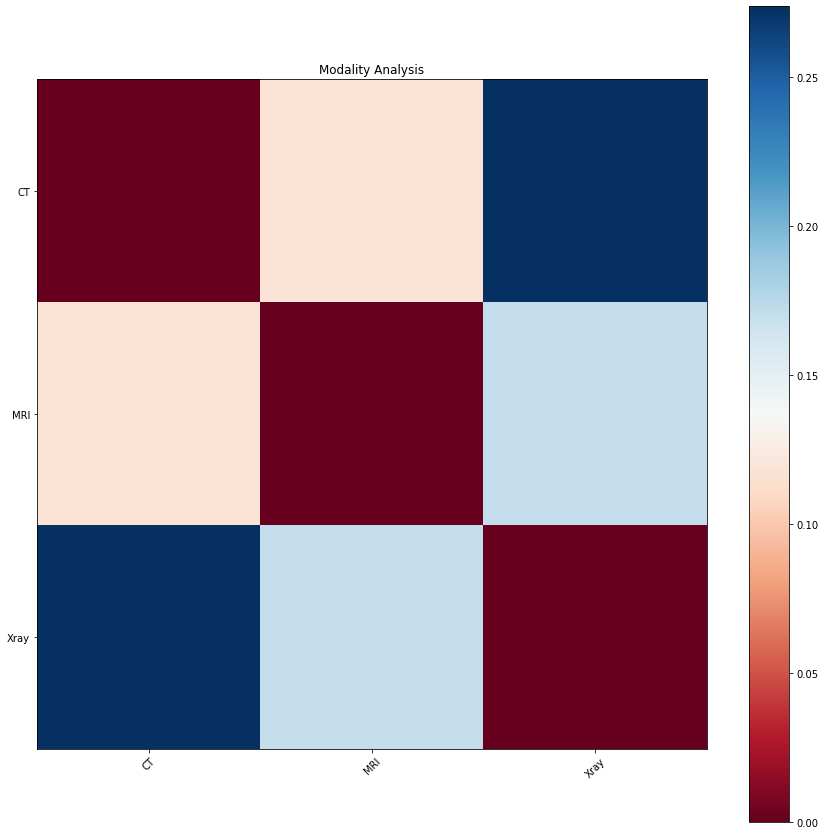

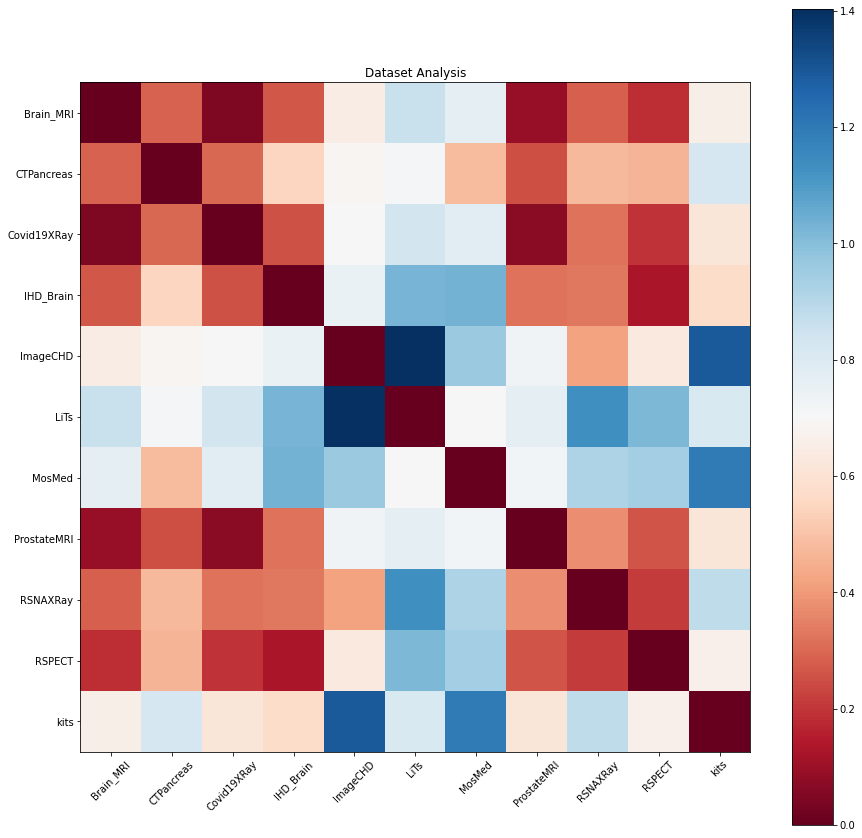

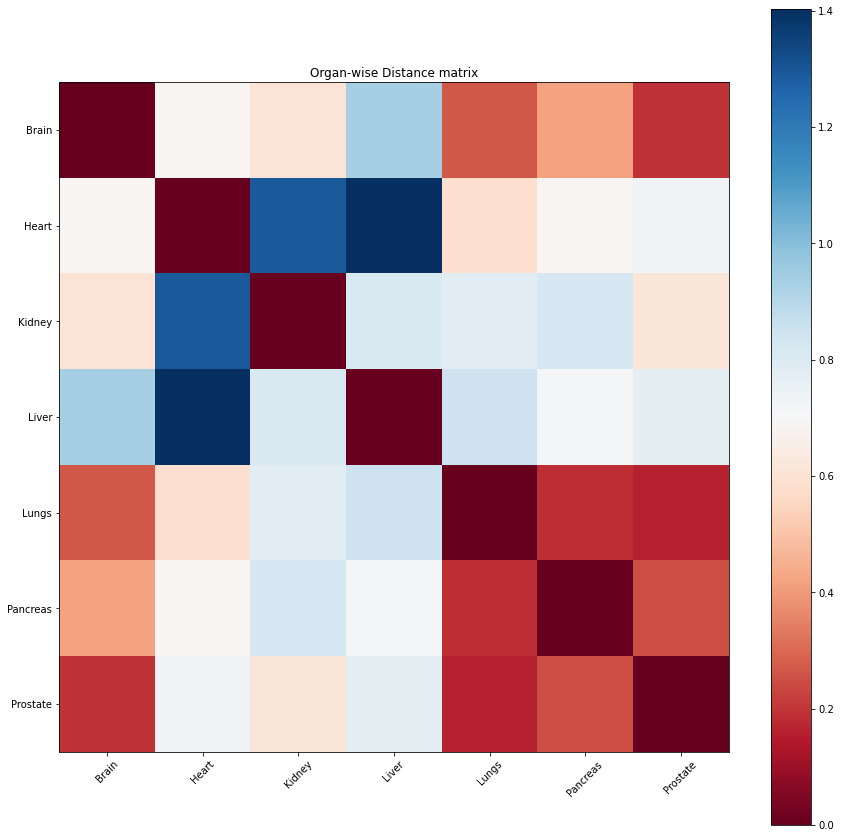

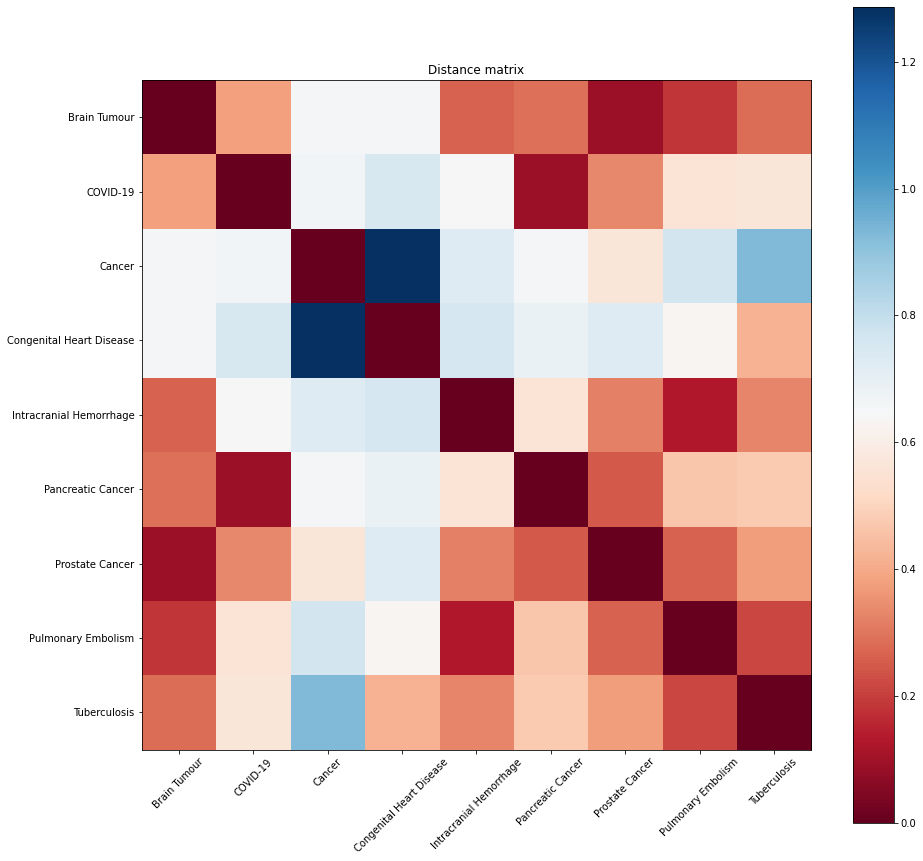

In [47]:
dist_from = 'pca' # 'emb' or 'pca' or 'tsne' or 'isomap' or 'lle'
emb = 'avg' # calculated as avg embedding over all model,dataset embeddings

dataset_only = filter(groupby = 'dataset', emb= emb, dist_from = dist_from)
by_organ = filter(groupby='organ', emb=emb, dist_from = dist_from)
by_modality = filter(groupby='modality', emb=emb, dist_from = dist_from)
by_pathology = filter(groupby='pathologies', emb=emb, dist_from = dist_from)
# Visualize embeddings in a scatterplot
distances, labels = get_distances(by_modality, dist_from = dist_from)
visualize_distances(distances, labels, 'Modality Analysis', log_scale = False)
distances, labels = get_distances(dataset_only, dist_from = dist_from)
visualize_distances(distances, labels, 'Dataset Analysis')
distances, labels = get_distances(by_organ, dist_from = dist_from)
visualize_distances(distances, labels, 'Organ-wise Distance matrix')
distances, labels = get_distances(by_pathology, dist_from = dist_from)
visualize_distances(distances, labels, 'Distance matrix')



results = {'model_zoo': f_model_zoo, 'd_pca': d['pca'], 'd_tsne': d['tsne'], 'd_isomap': d['isomap'], 'd_lle': d['lle'], 'true_distances': true_distances, 'labels_for_distances' : true['dataset']}

torch.save(results, 'results.pt')

torch.load('results.pt')

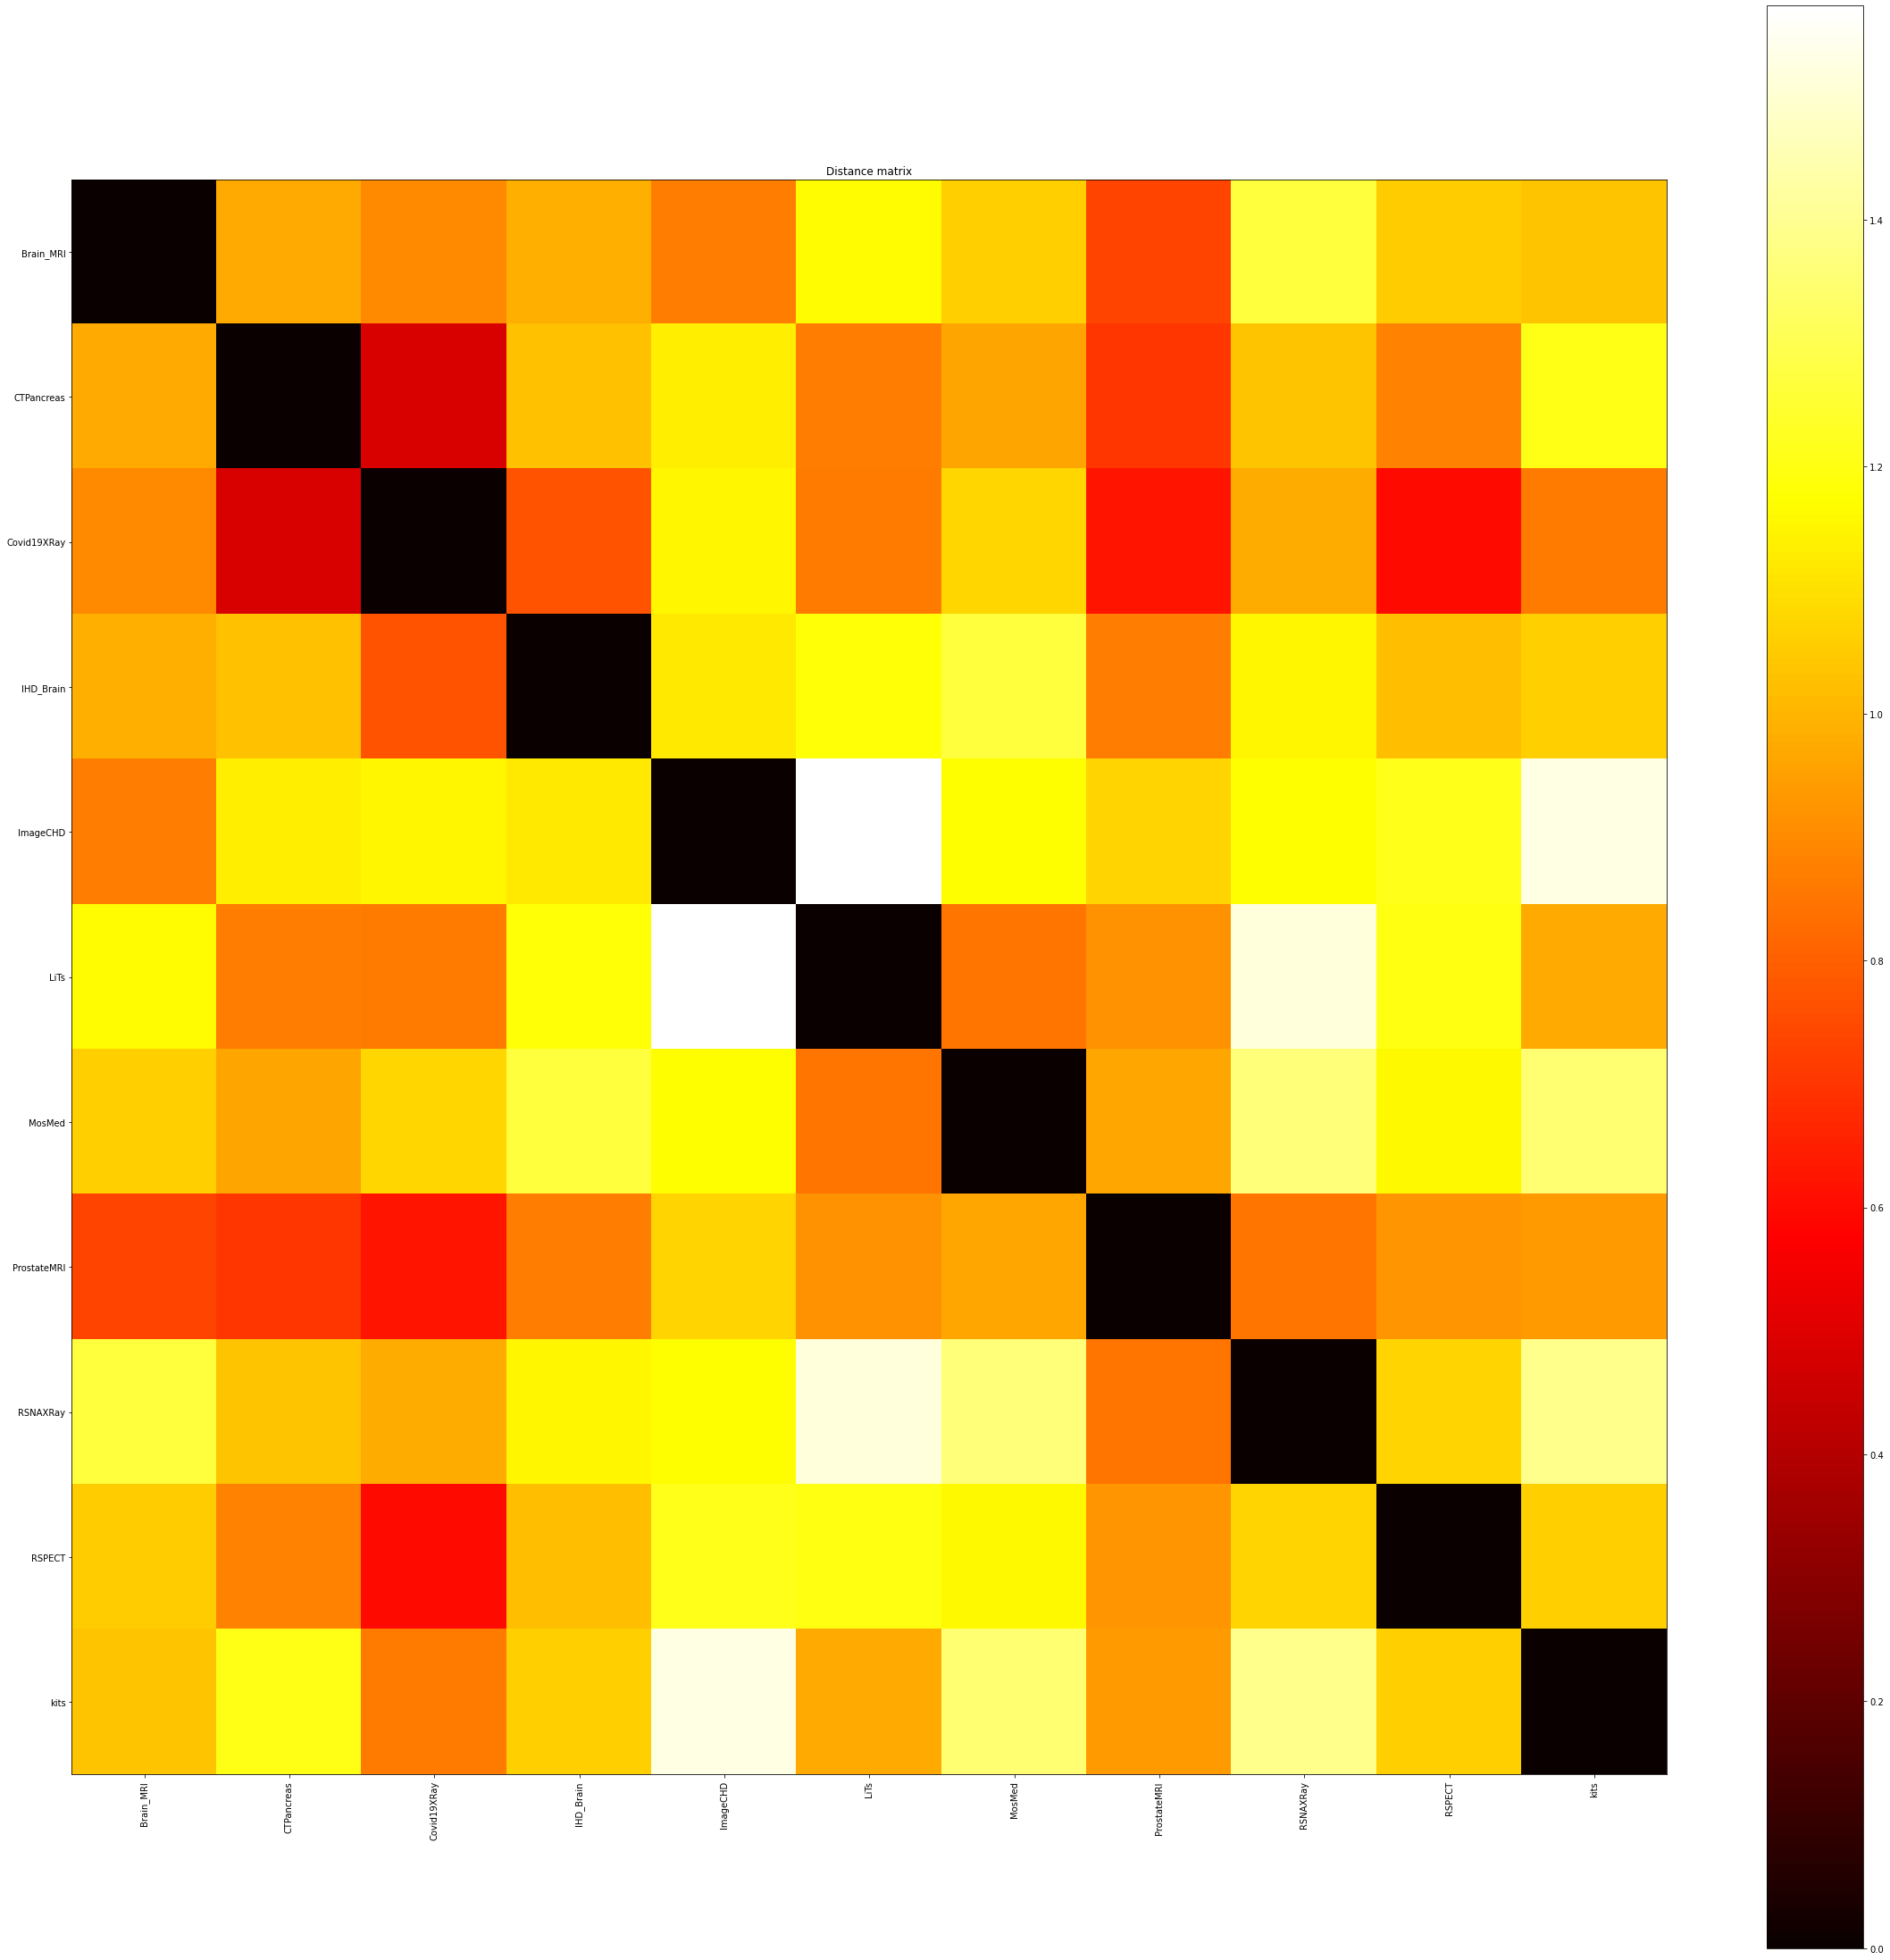

In [253]:
import d3fdgraph
import pandas as pd
d3fdgraph.plot_force_directed_graph(matrix_to_pairwise(distances))

force-directed graph

In [30]:
# plot distance matrix true_distances with labels true['dataset']
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distances(results):
    plt.figure(figsize=(40, 40))
    sns.heatmap(results['true_distances'], xticklabels=results['labels_for_distances'], yticklabels=results['labels_for_distances'], annot=True, fmt='.2f', cmap='viridis')
    plt.title('True distances')
    plt.show()

In [33]:
plot_distances(results)

In [32]:
def plot_distance_matrix(results, method):
    plt.figure(figsize=(40, 40))
    sns.heatmap(results[method], xticklabels=results['labels_for_distances'], yticklabels=results['labels_for_distances'], annot=True, fmt='.2f', cmap='viridis')
    plt.title('Euclidian error for %s'%method)
    plt.show()

In [ ]:
for method in ['d_pca', 'd_tsne', 'd_isomap', 'd_lle']:
    plot_distance_matrix(results, method)

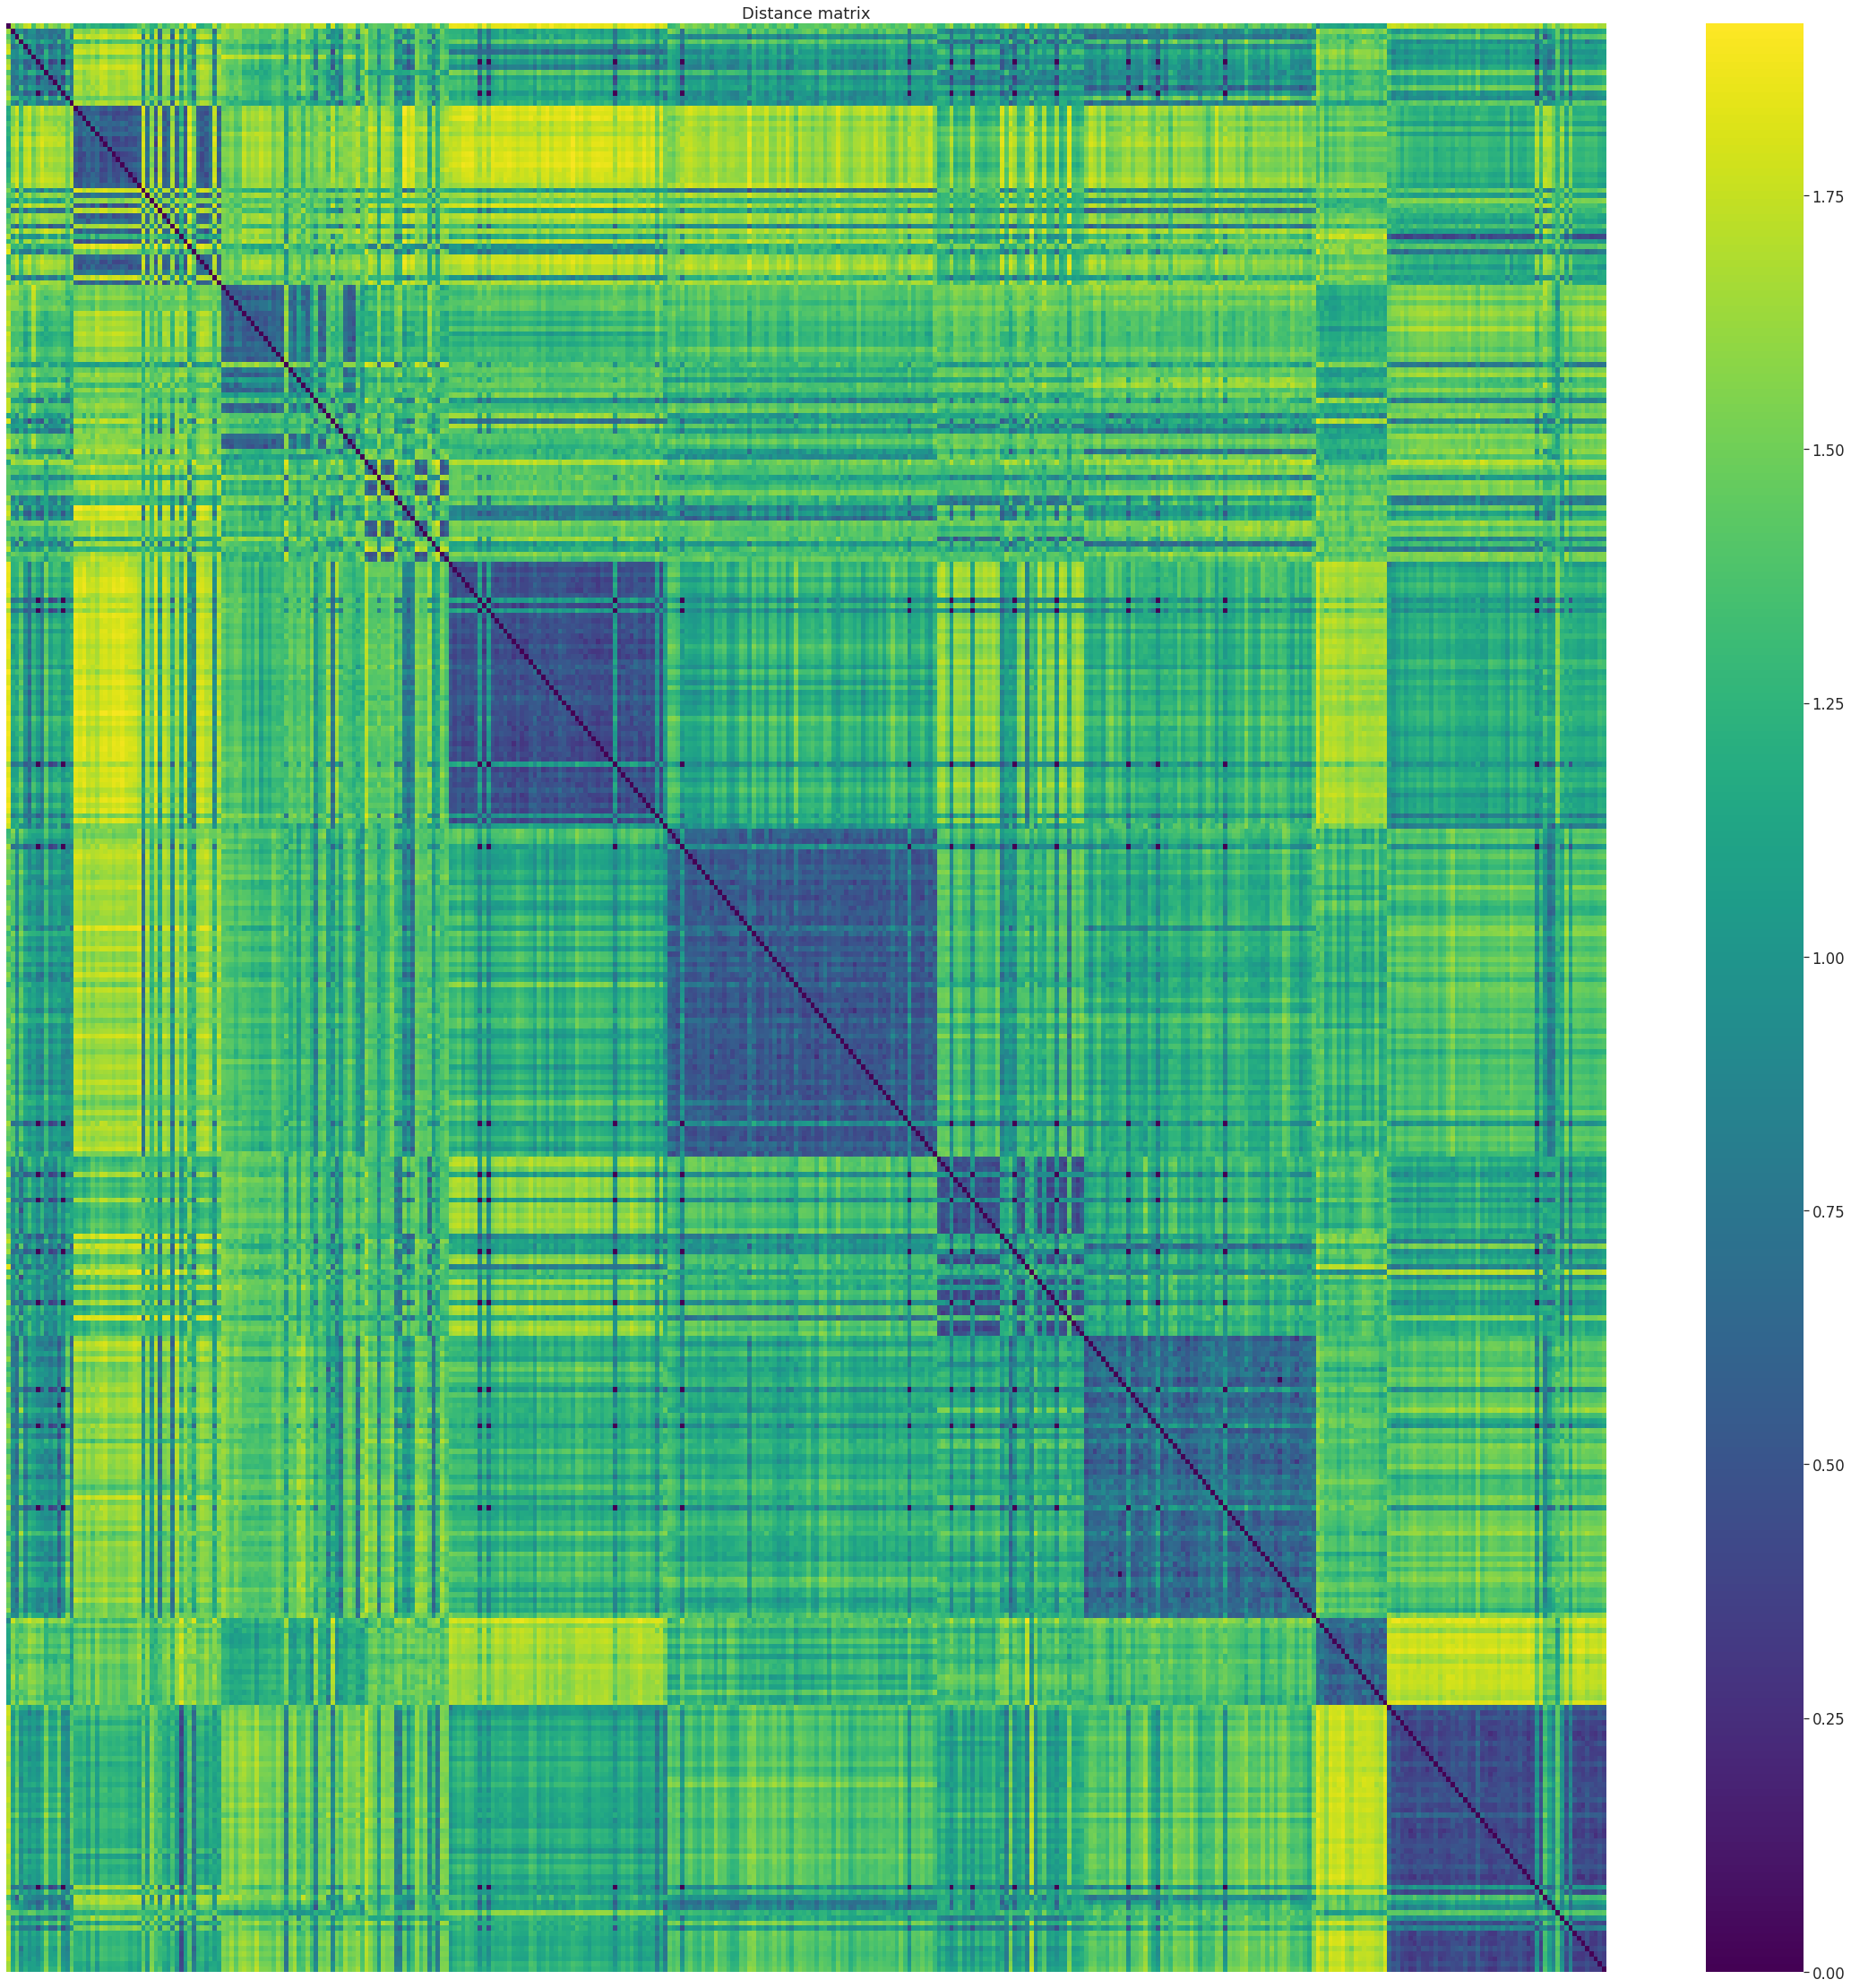

In [59]:
plot_distance_matrix(true_distances, [])

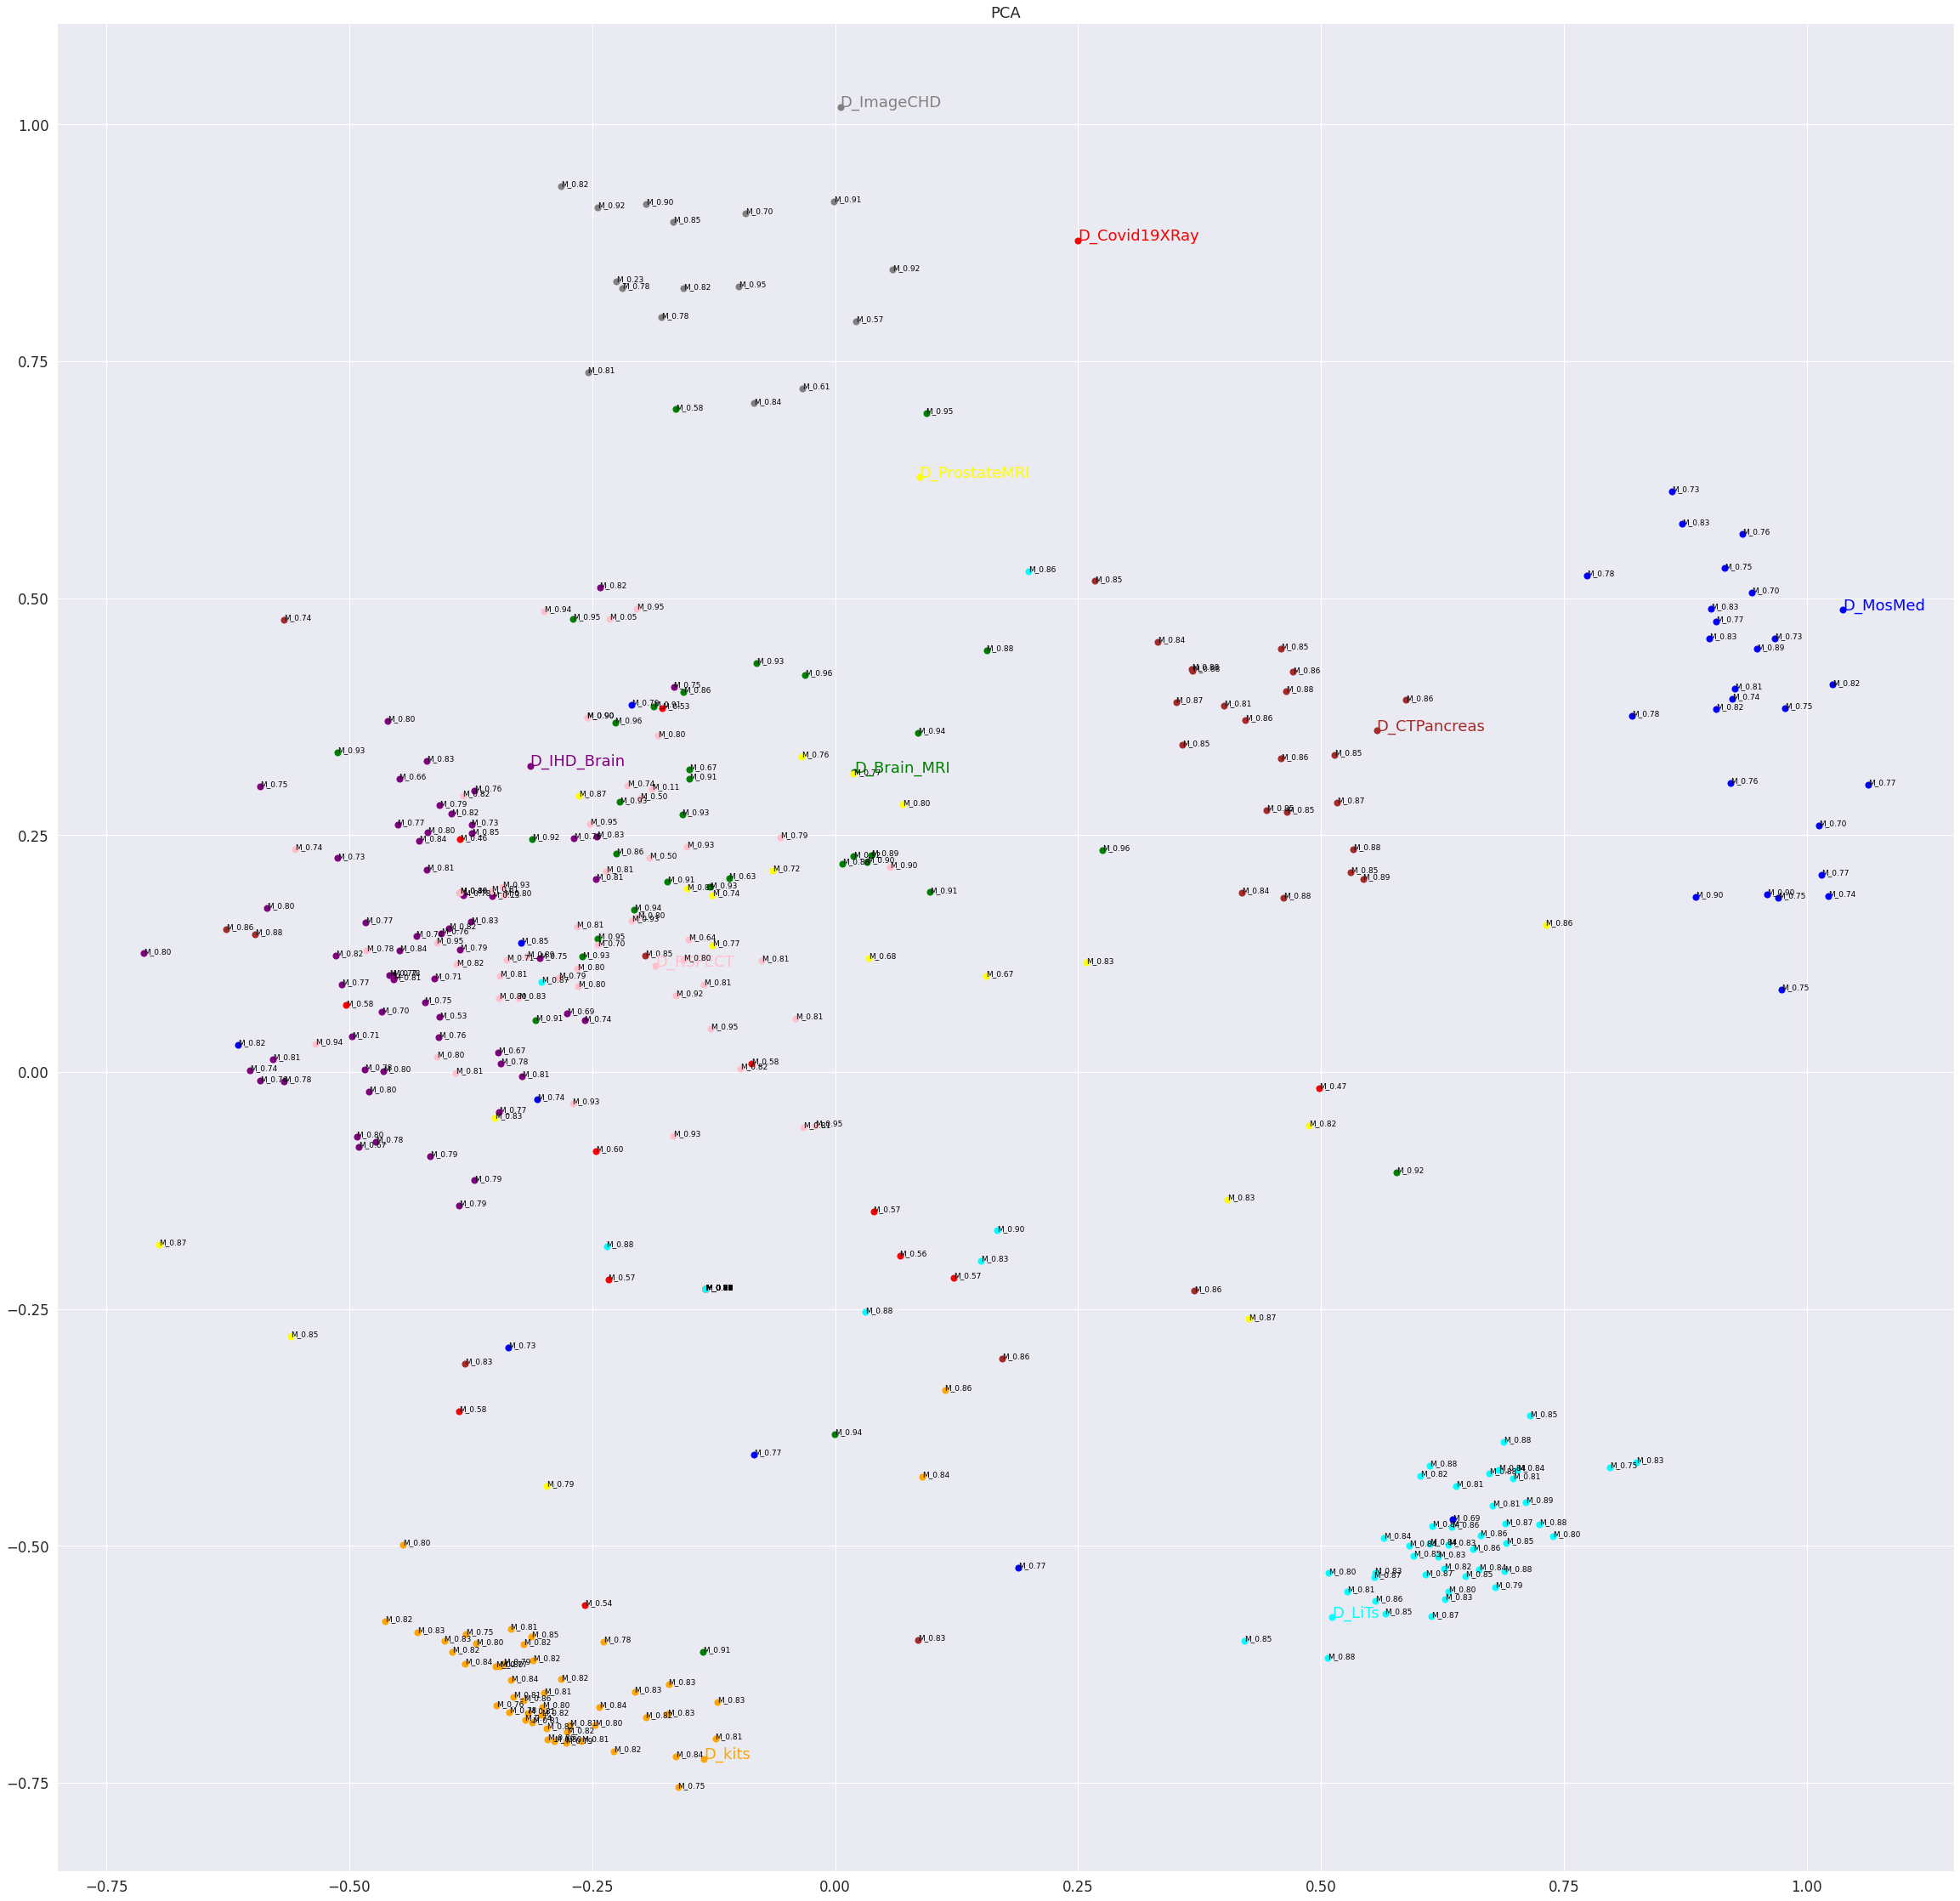

In [75]:
# PCA Visualization
visualize_embeddings(data_emb_list, 'PCA', 'pca', return_emb=False)

# LLE Visualization
visualize_embeddings(data_emb_list, 'LLE', 'lle', return_emb=False)


/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 327 samples in 0.001s...
[t-SNE] Computed neighbors for 327 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 327 / 327
[t-SNE] Mean sigma: 0.368569
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.046753
[t-SNE] KL divergence after 300 iterations: 0.155269


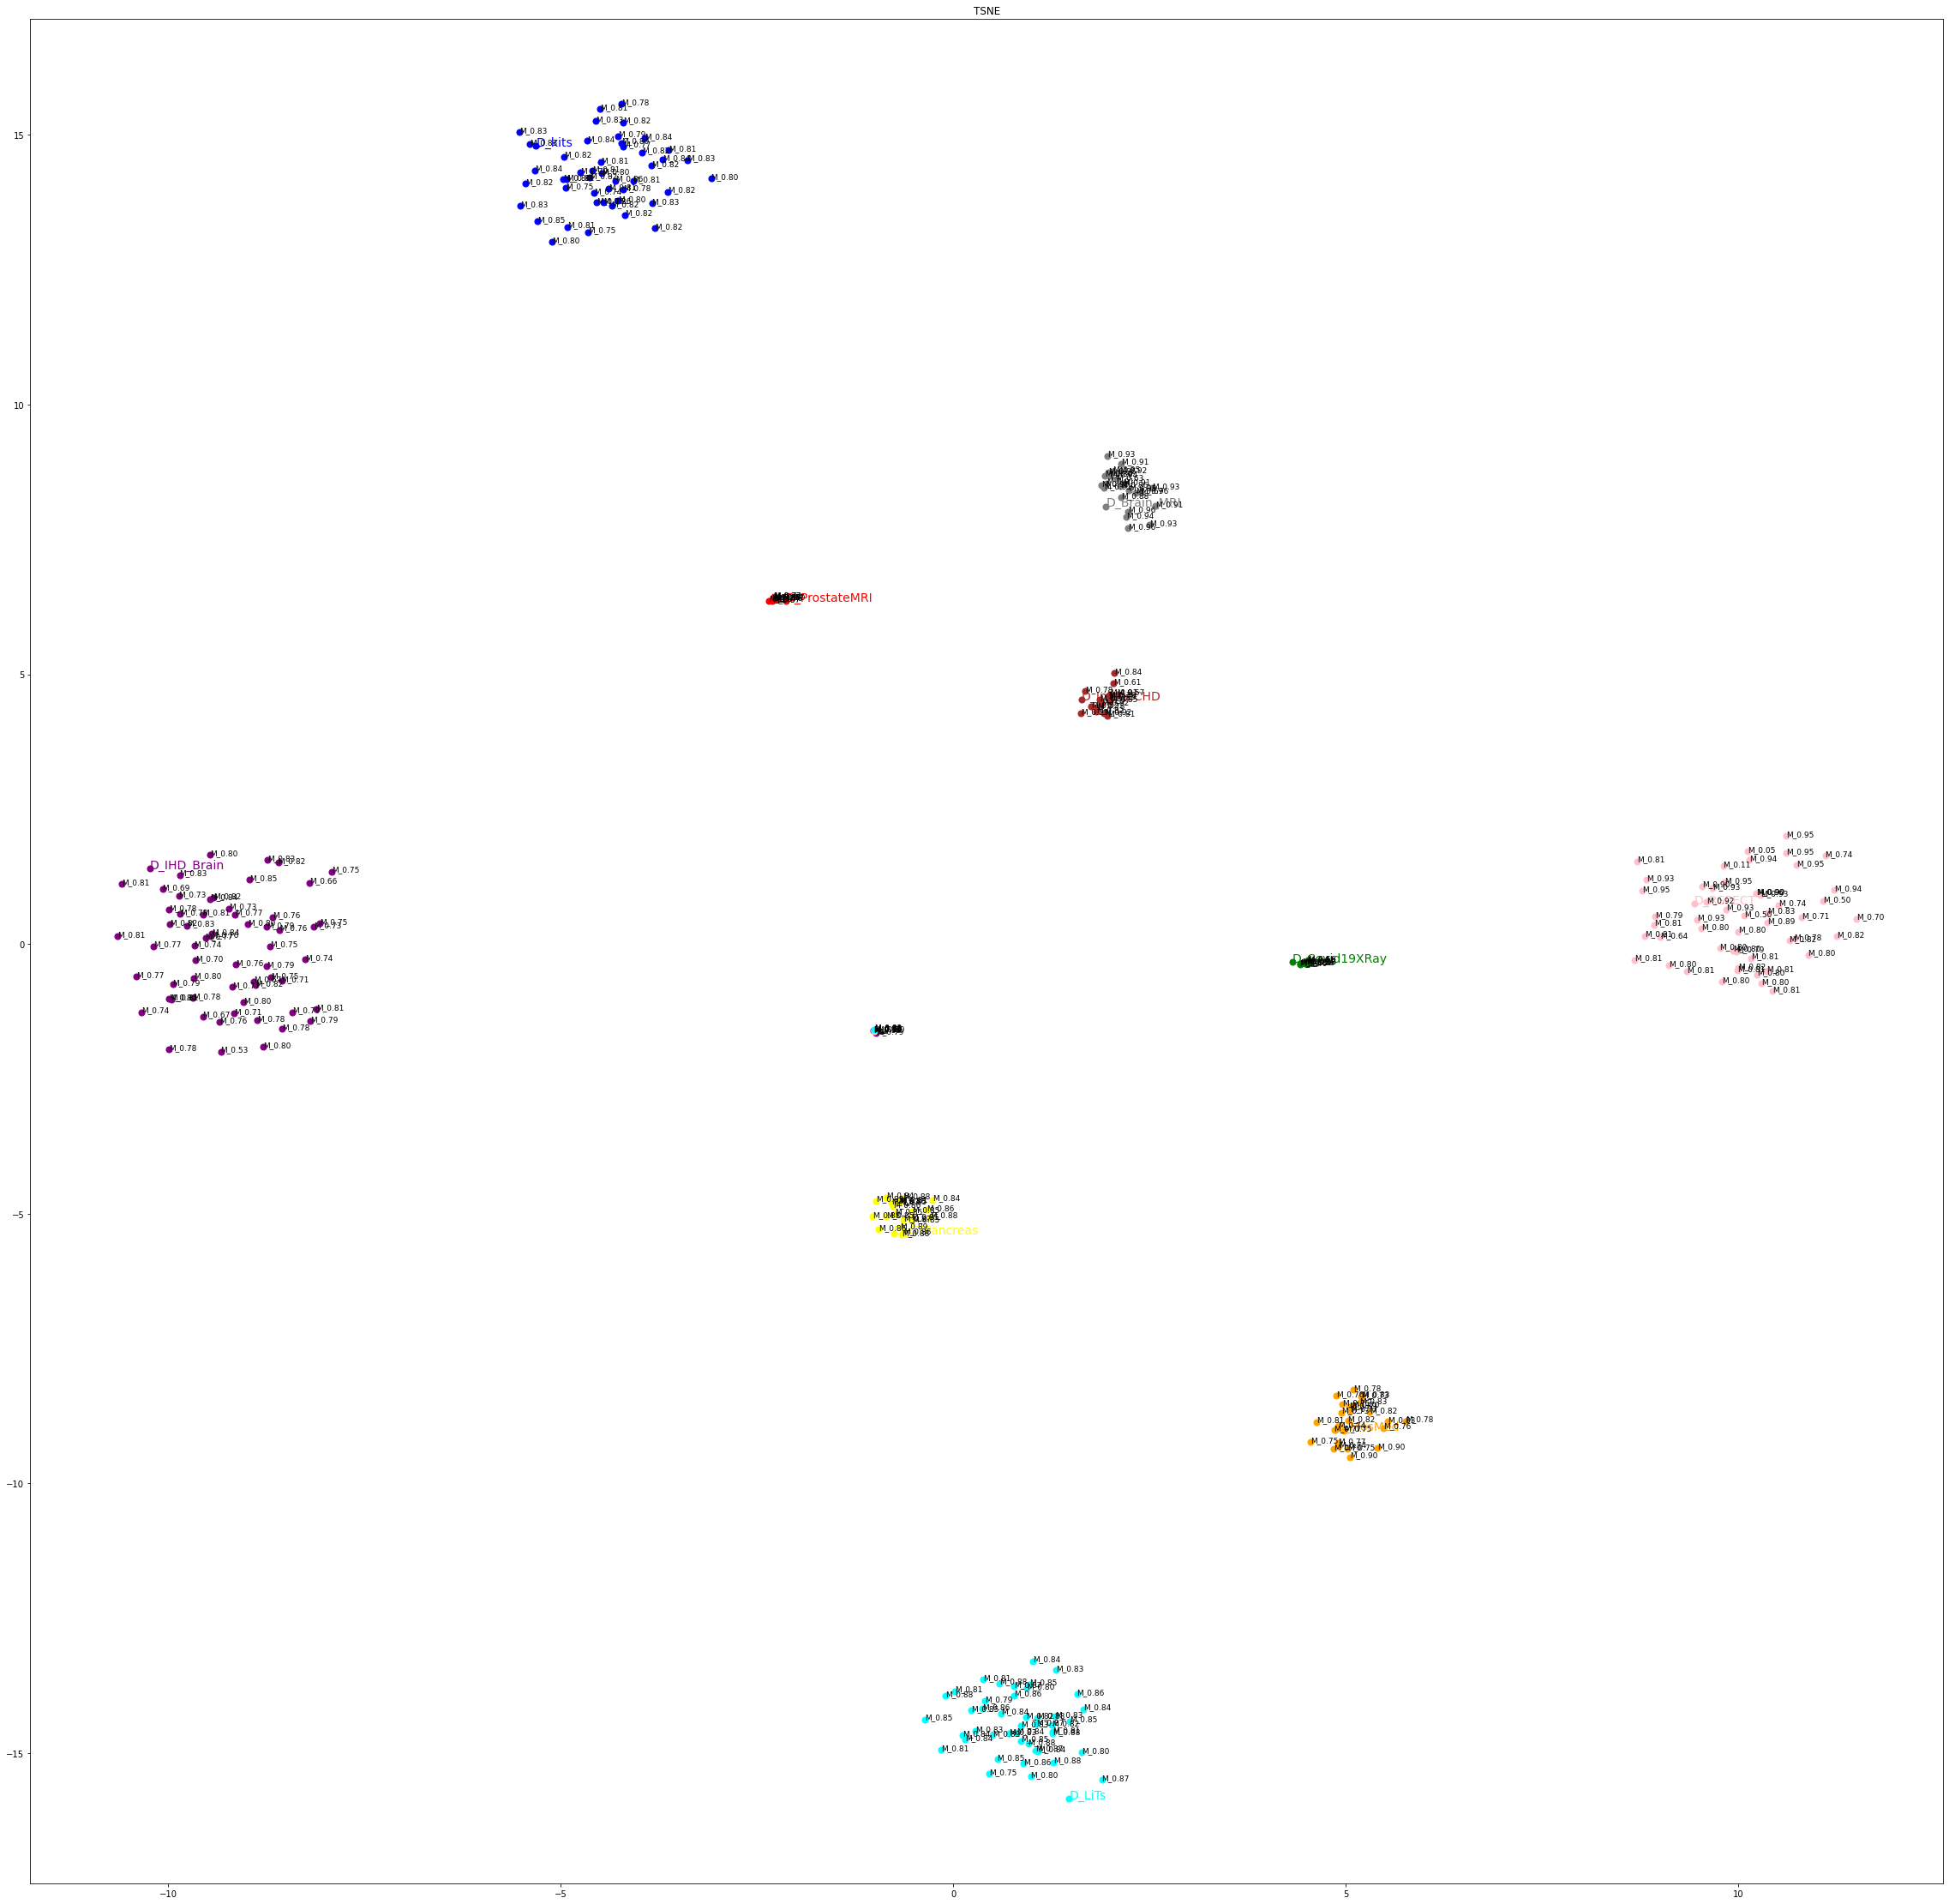

In [26]:
# TSNE Visualization
visualize_embeddings(data_emb_list, 'TSNE', 'tsne', return_emb=False)

# Isomap Visualization
visualize_embeddings(data_emb_list, 'Isomap', 'isomap', return_emb=False)

In [28]:
# Use plotly to plot force directed graph representation of the distance matrix
import plotly.graph_objs as go

def plot_graph(distances, labels, title):
    x = [d[0] for d in distances]
    y = [d[1] for d in distances]
    z = [d[2] for d in distances]
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=12,
            color=labels,
            colorscale='Viridis',
            opacity=0.8
        )
    )
    layout = go.Layout(
        title=title,
        width=800,
        height=800,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        scene=dict(
            xaxis=dict(
                title='PC1',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title='PC2',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            ),
            zaxis=dict(
                title='PC3',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            )
        )
    )
    fig = go.Figure(data=[trace1], layout=layout)
    fig.show()



In [29]:
plot_graph(true_emb, true['color'], 'True Embeddings')